In [6]:
!pip install geopandas pyproj shapely igraph

In [7]:
import json
import geopandas as gpd
from shapely.geometry import shape, LineString
from shapely.wkb import loads as wkb_loads
from shapely.strtree import STRtree
import igraph as ig
import multiprocessing as mp
from tqdm.auto import tqdm
from functools import partial

# Global variables for notebook persistence
GDF = None
GRAPH = None
EDGES = None

def load_geojson(filepath):
    """Load and validate LineString features with progress"""
    with open(filepath) as f:
        data = json.load(f)

    features = []
    for feature in tqdm(data['features'], desc="Loading features"):
        geom = feature['geometry']
        if geom['type'] == 'LineString' and len(geom['coordinates']) >= 2:
            try:
                shp = shape(geom)
                if shp.is_valid:
                    features.append({
                        'geometry': shp,
                        'properties': feature['properties']
                    })
            except Exception as e:
                continue
    return gpd.GeoDataFrame(features).reset_index(drop=True)

def spatial_index(gdf):
    """Build spatial index and find candidate pairs with progress"""
    tree = STRtree(gdf.geometry)
    candidates = set()

    for i, geom in tqdm(enumerate(gdf.geometry), total=len(gdf), desc="Finding candidates"):
        for j in tree.query(geom, predicate='intersects'):
            if i < j:
                candidates.add((i, j))

    return sorted(candidates)

def worker_init(geoms_wkb):
    """Initialize worker with geometries"""
    global worker_geoms
    worker_geoms = [wkb_loads(wkb) for wkb in geoms_wkb]

def check_intersection(pair):
    """Worker function for intersection check"""
    i, j = pair
    try:
        return (i, j) if worker_geoms[i].intersects(worker_geoms[j]) else None
    except Exception:
        return None

def find_edges(gdf, candidates, workers):
    """Parallel intersection check with proper data handling"""
    # Properly serialize geometries as WKB
    geoms_wkb = [geom.wkb for geom in gdf.geometry]

    with mp.Pool(
        workers,
        initializer=worker_init,
        initargs=(geoms_wkb,)
    ) as pool:
        results = list(tqdm(
            pool.imap_unordered(check_intersection, candidates, chunksize=1000),
            total=len(candidates),
            desc="Checking intersections"
        ))

    return [r for r in results if r is not None]

def create_network():
    """Main function for creating the network"""
    global GDF, GRAPH, EDGES

    # Configuration
    INPUT_FILE = "/content/drive/MyDrive/NETWORK_SCIENCE/filtered_trunk.geojson"
    WORKERS = max(1, mp.cpu_count() - 1)  # Leave one CPU free

    # Load data
    GDF = load_geojson(INPUT_FILE)
    print(f"Loaded {len(GDF):,} valid LineStrings")

    # Find candidates
    candidates = spatial_index(GDF)
    print(f"Found {len(candidates):,} candidate pairs")

    # Find actual intersections
    EDGES = find_edges(GDF, candidates, WORKERS)
    print(f"Found {len(EDGES):,} intersecting pairs")

    # Build graph
    GRAPH = ig.Graph()
    GRAPH.add_vertices(len(GDF))
    GRAPH.add_edges(EDGES)
    print("\nNetwork summary:")
    print(GRAPH.summary())

    # Return values for direct assignment if needed
    return GDF, GRAPH, EDGES

GDF, GRAPH, EDGES = create_network()

Loading features:   0%|          | 0/116571 [00:00<?, ?it/s]

Loaded 116,571 valid LineStrings


Finding candidates:   0%|          | 0/116571 [00:00<?, ?it/s]

Found 125,820 candidate pairs


Checking intersections:   0%|          | 0/125820 [00:00<?, ?it/s]

Found 125,820 intersecting pairs

Network summary:
IGRAPH U--- 116571 125820 -- 


In [8]:
!pip install plotly

In [9]:
# Download country boundaries from Natural Earth
import geopandas as gpd
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#india = world[world.name == 'India'].geometry.iloc[0]

# Alternatively, use GADM data for more detailed boundaries:
india = gpd.read_file("https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_IND_0.json")

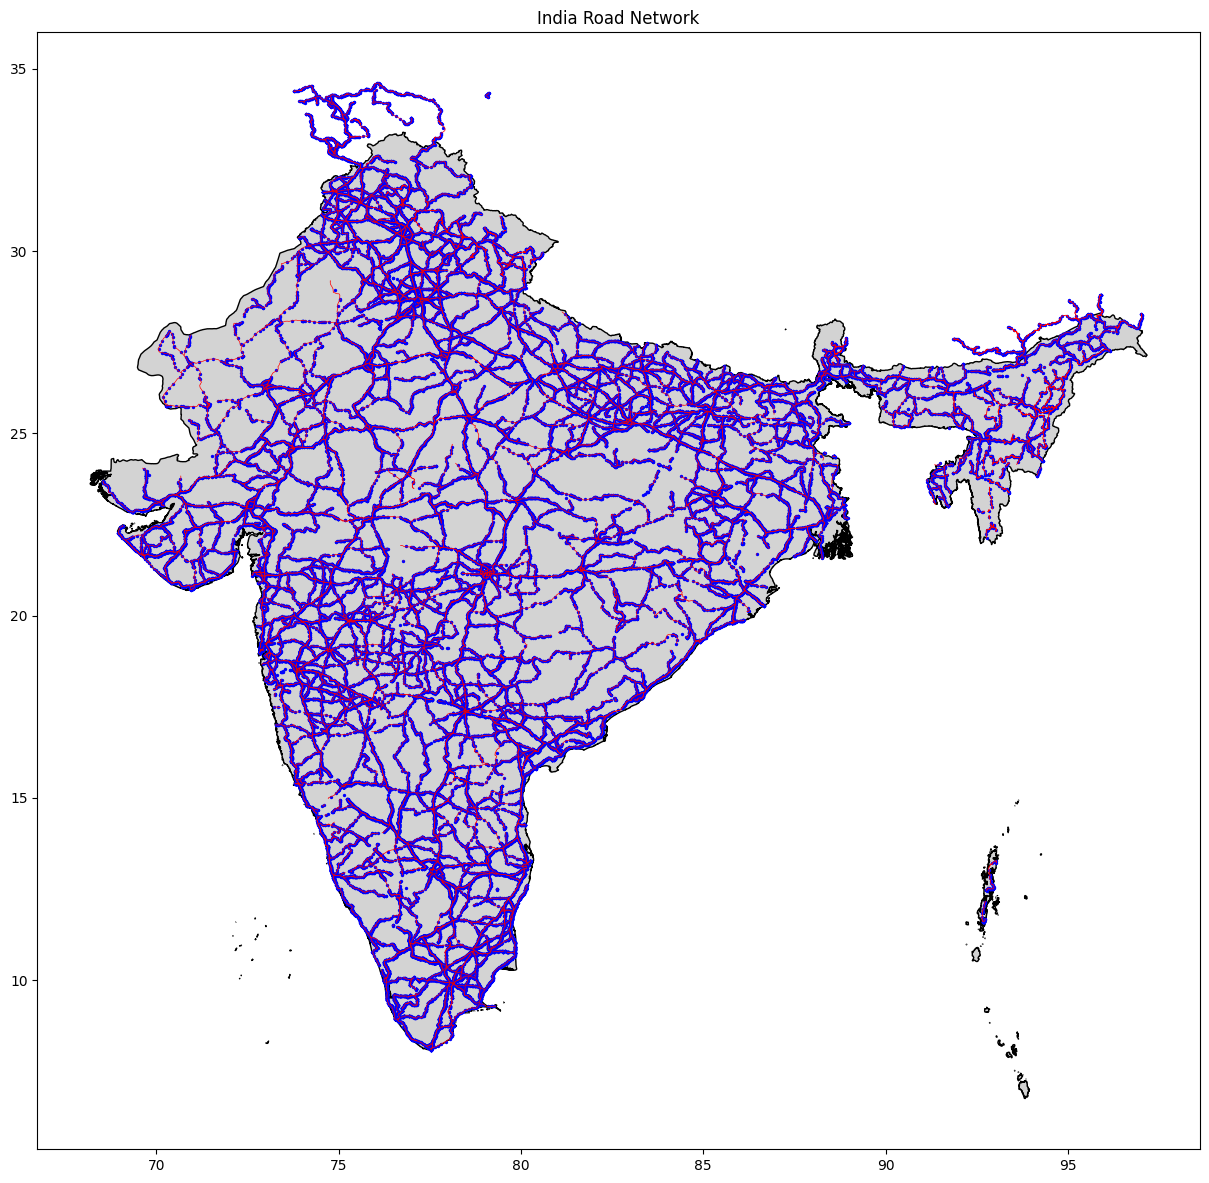

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))

# Plot India boundary
# Access the geometry column and the first element to get the Polygon
gpd.GeoSeries([india.geometry.iloc[0]]).plot(ax=ax, color='lightgray', edgecolor='black')

# Plot roads
GDF.plot(ax=ax, linewidth=0.5, color='red')

# Add graph nodes
GDF.geometry.centroid.plot(ax=ax, color='blue', markersize=2)

plt.title("India Road Network")
plt.show()

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import gc  # Garbage collector
import random

# Print basic network size info
network_size = GRAPH.vcount()
edge_count = GRAPH.ecount()
print(f"Network size: {network_size:,} nodes and {edge_count:,} edges")

# Memory-efficient centrality calculation
# -----------------------------------------

# 1. Calculate degree (most basic measure, should always work)
print("Calculating degree centrality...")
degree_values = GRAPH.degree()

# 2. Calculate local clustering coefficient (neighborhood-based, memory efficient)
print("Calculating local clustering coefficient...")
try:
    clustering_values = GRAPH.transitivity_local_undirected(mode="zero")
except Exception as e:
    print(f"Error calculating clustering: {str(e)}")
    clustering_values = [0] * network_size

# Create DataFrames with smaller samples for visualization
# Taking 10,000 random samples to avoid memory issues
print("Preparing data for visualization...")
sample_size = min(10000, network_size)
sample_indices = random.sample(range(network_size), sample_size)

degree_sample = [degree_values[i] for i in sample_indices]
clustering_sample = [clustering_values[i] for i in sample_indices]

# Clear memory
gc.collect()

# Calculate top nodes by degree
print("Finding key nodes...")
top_degree_indices = sorted(range(len(degree_values)),
                            key=lambda i: degree_values[i],
                            reverse=True)[:20]

Network size: 116,571 nodes and 125,820 edges
Calculating degree centrality...
Calculating local clustering coefficient...
Preparing data for visualization...
Finding key nodes...


Plotting degree distribution...


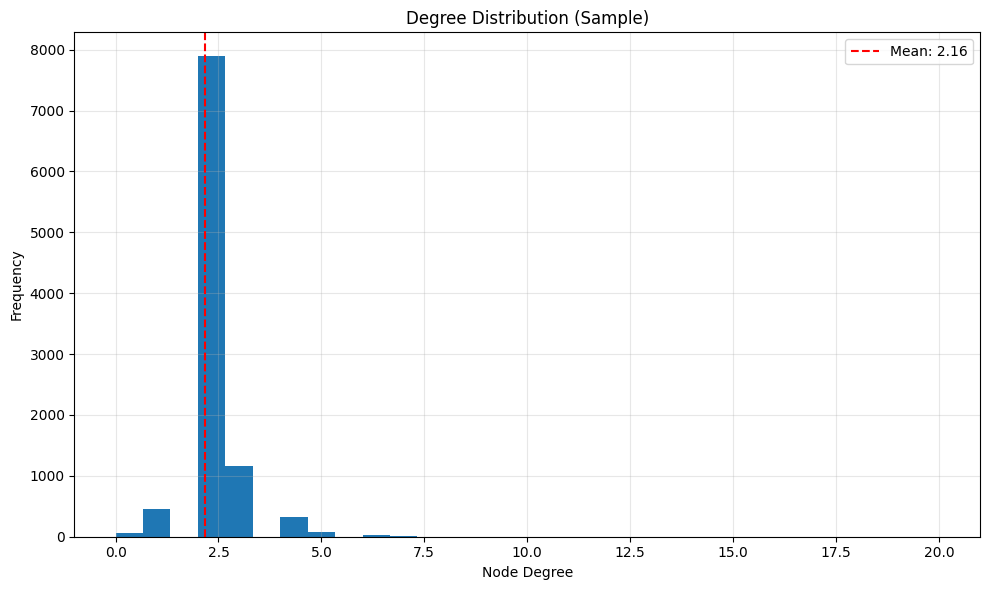

2926476

In [12]:
# Plot degree distribution
print("Plotting degree distribution...")
plt.figure(figsize=(10, 6))
plt.hist(degree_sample, bins=30)
plt.title('Degree Distribution (Sample)')
plt.xlabel('Node Degree')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.axvline(np.mean(degree_sample), color='red', linestyle='--',
           label=f'Mean: {np.mean(degree_sample):.2f}')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

# Clear memory again
gc.collect()

Plotting clustering coefficient distribution...


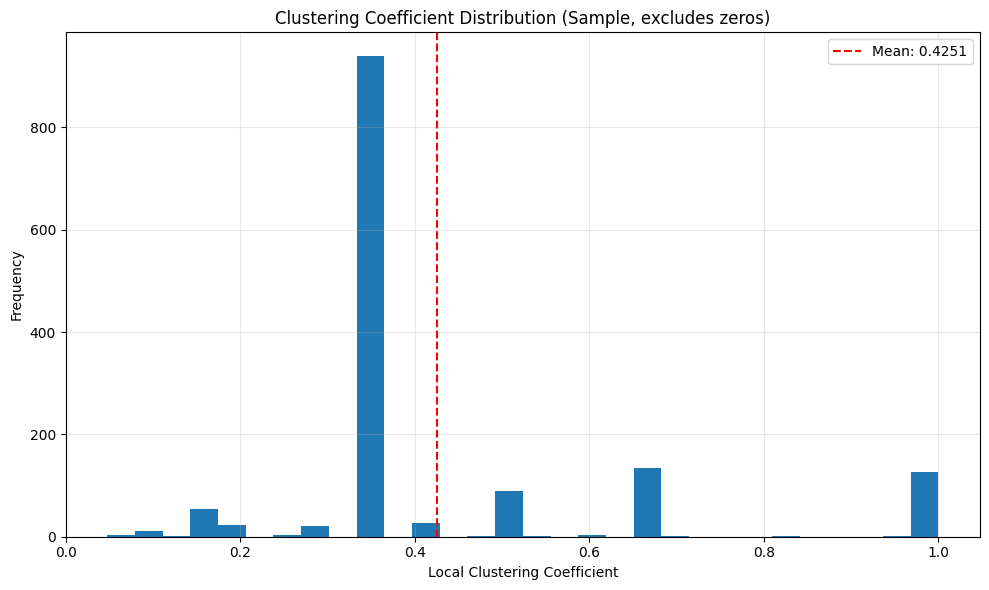

4762

In [13]:
# Plot clustering coefficient
print("Plotting clustering coefficient distribution...")
plt.figure(figsize=(10, 6))
plt.hist([c for c in clustering_sample if c > 0], bins=30)
plt.title('Clustering Coefficient Distribution (Sample, excludes zeros)')
plt.xlabel('Local Clustering Coefficient')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
non_zero = [c for c in clustering_sample if c > 0]
if non_zero:
    plt.axvline(np.mean(non_zero), color='red', linestyle='--',
               label=f'Mean: {np.mean(non_zero):.4f}')
    plt.legend()
plt.tight_layout()
plt.show()
plt.close()

# Clear memory again
gc.collect()

Plotting log-log degree distribution...


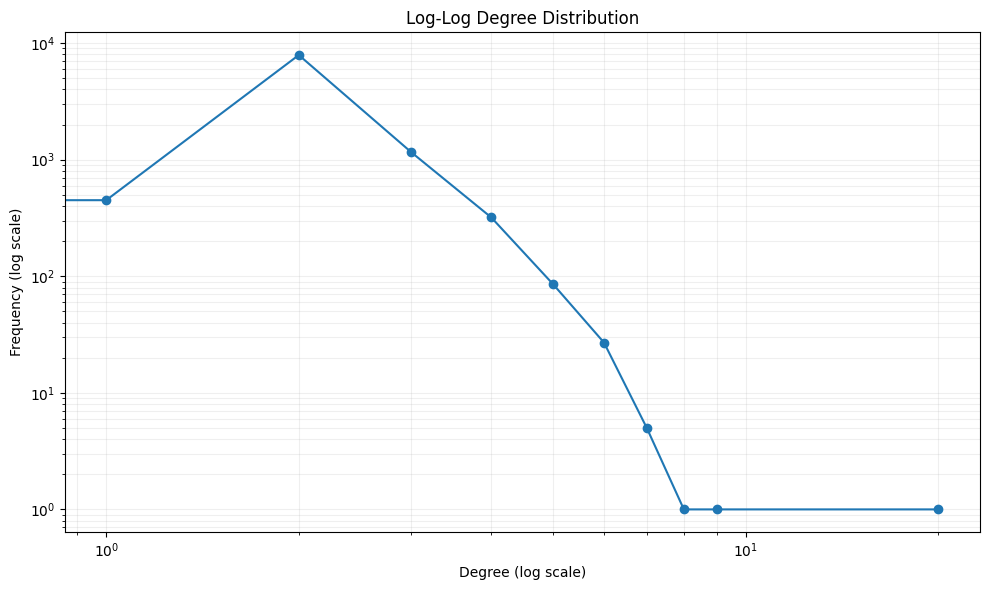

19832

In [14]:
# Log-log degree distribution (common for scale-free networks)
print("Plotting log-log degree distribution...")
degree_counts = {}
for d in degree_sample:
    degree_counts[d] = degree_counts.get(d, 0) + 1

x = sorted(degree_counts.keys())
y = [degree_counts[k] for k in x]

plt.figure(figsize=(10, 6))
plt.loglog(x, y, 'o-')
plt.title('Log-Log Degree Distribution')
plt.xlabel('Degree (log scale)')
plt.ylabel('Frequency (log scale)')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.tight_layout()
plt.show()
plt.close()

gc.collect()


Network has 116,571 nodes and 125,820 edges
Using 1 CPU cores for parallel processing
Calculating betweenness centrality in 234 batches of 500 nodes...
Using path length cutoff of 5
Initial memory usage: 1123.71 MB


  0%|          | 0/234 [00:00<?, ?it/s]

Processed 1/234 batches (0.4%)
Elapsed time: 1.1 seconds (0.0 minutes)
Current memory usage: 1132.70 MB (Change: 8.99 MB)
Processed 11/234 batches (4.7%)
Elapsed time: 8.1 seconds (0.1 minutes)
Current memory usage: 1132.71 MB (Change: 9.00 MB)
Processed 21/234 batches (9.0%)
Elapsed time: 13.9 seconds (0.2 minutes)
Current memory usage: 1132.71 MB (Change: 9.00 MB)
Processed 31/234 batches (13.2%)
Elapsed time: 21.0 seconds (0.4 minutes)
Current memory usage: 1132.71 MB (Change: 9.00 MB)
Processed 41/234 batches (17.5%)
Elapsed time: 26.9 seconds (0.4 minutes)
Current memory usage: 1132.71 MB (Change: 9.00 MB)
Processed 51/234 batches (21.8%)
Elapsed time: 33.6 seconds (0.6 minutes)
Current memory usage: 1132.71 MB (Change: 9.00 MB)
Processed 61/234 batches (26.1%)
Elapsed time: 39.8 seconds (0.7 minutes)
Current memory usage: 1132.71 MB (Change: 9.00 MB)
Processed 71/234 batches (30.3%)
Elapsed time: 46.2 seconds (0.8 minutes)
Current memory usage: 1132.71 MB (Change: 9.00 MB)
Proces

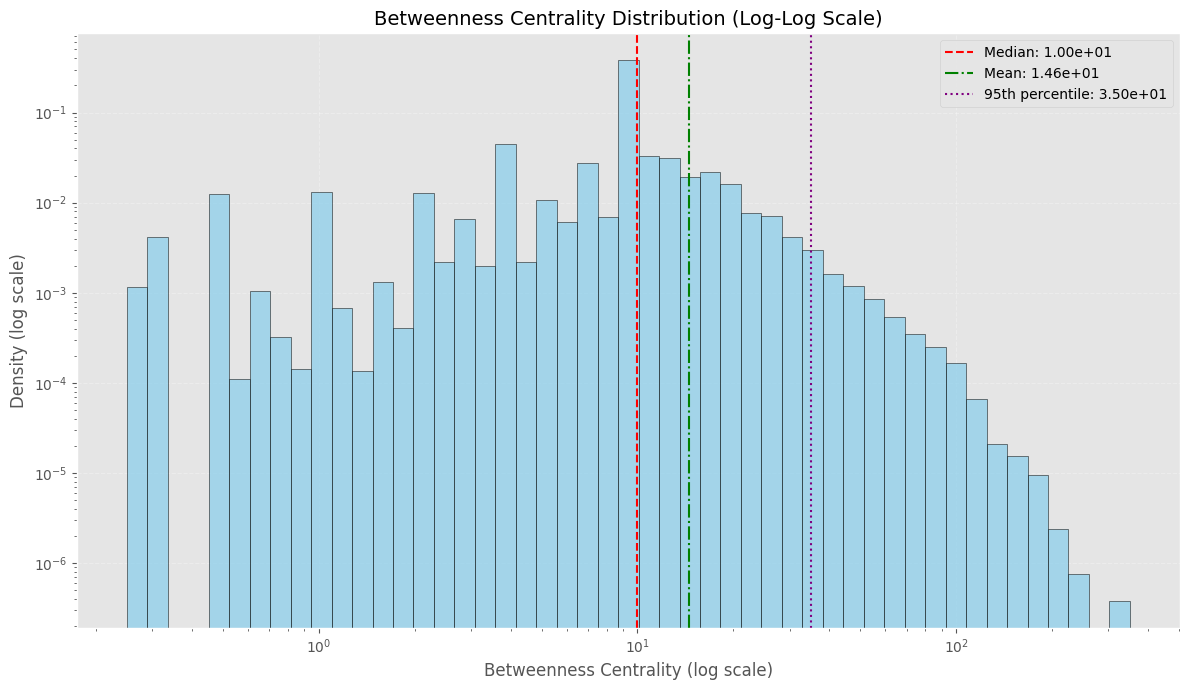

'\nprint("\nCalculating approximate betweenness using sampling...")\nsample_size = min(5000, GRAPH.vcount())  # Sample size, adjust based on your needs\nstart_time = time.time()\n\n# Calculate betweenness using sampling for faster results\napprox_betweenness = GRAPH.betweenness(\n    vertices=None,  # Calculate for all nodes\n    directed=False,\n    cutoff=cutoff_value,\n    weights=None,\n    nobigint=True,\n    samples=sample_size  # Monte Carlo sampling\n)\n\nprint(f"Approximate betweenness calculation complete in {(time.time() - start_time)/60:.2f} minutes")\nnp.save("approx_betweenness_values.npy", approx_betweenness)\n'

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import gc  # Garbage collector
from tqdm.auto import tqdm
import time
import multiprocessing as mp
from functools import partial
import psutil  # For memory monitoring (install with pip if needed)

# Function to calculate betweenness for a batch of nodes
def calculate_batch_betweenness(batch_info, graph, cutoff=None):
    batch_idx, start_idx, end_idx = batch_info
    batch_vertices = list(range(start_idx, end_idx))

    try:
        # Calculate betweenness for this batch of nodes
        batch_result = graph.betweenness(
            vertices=batch_vertices,
            directed=False,
            cutoff=cutoff  # Using cutoff for speed
        )

        # Force garbage collection
        gc.collect()

        return batch_idx, batch_vertices, batch_result

    except Exception as e:
        print(f"Error processing batch {batch_idx}: {str(e)}")
        return batch_idx, batch_vertices, [0] * len(batch_vertices)

# Memory usage monitoring
def get_memory_usage():
    process = psutil.Process()
    return process.memory_info().rss / (1024 * 1024)  # Convert to MB

print(f"Network has {GRAPH.vcount():,} nodes and {GRAPH.ecount():,} edges")

# Parameters for batch processing
batch_size = 500  # Smaller batch size for better parallelization
num_batches = (GRAPH.vcount() + batch_size - 1) // batch_size
betweenness_values = np.zeros(GRAPH.vcount())

# For large graphs, use a cutoff to limit path length
# For a graph with 116k nodes, a cutoff of 4-6 might provide a good balance
# Try different cutoff values to find the sweet spot between speed and accuracy
cutoff_value = 5  # Adjust based on network diameter and analysis needs

# Determine number of parallel processes (leave some cores free)
num_cores = max(1, mp.cpu_count() - 2)
print(f"Using {num_cores} CPU cores for parallel processing")

print(f"Calculating betweenness centrality in {num_batches} batches of {batch_size} nodes...")
print(f"Using path length cutoff of {cutoff_value}")
start_time = time.time()
initial_memory = get_memory_usage()
print(f"Initial memory usage: {initial_memory:.2f} MB")

# Prepare batch information
batch_info = []
for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, GRAPH.vcount())
    batch_info.append((batch_idx, start_idx, end_idx))

# Using a context manager for the process pool ensures proper cleanup
with mp.Pool(processes=num_cores) as pool:
    # Create a partial function with fixed arguments
    worker_func = partial(calculate_batch_betweenness, graph=GRAPH, cutoff=cutoff_value)

    # Process batches in parallel with progress tracking
    results = []
    for result in tqdm(pool.imap_unordered(worker_func, batch_info), total=num_batches):
        batch_idx, batch_vertices, batch_result = result

        # Store results
        for i, node_idx in enumerate(batch_vertices):
            betweenness_values[node_idx] = batch_result[i]

        # Track progress periodically
        if len(results) % 10 == 0 or len(results) == num_batches - 1:
            elapsed = time.time() - start_time
            current_memory = get_memory_usage()
            print(f"Processed {len(results) + 1}/{num_batches} batches ({(len(results) + 1)/num_batches*100:.1f}%)")
            print(f"Elapsed time: {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")
            print(f"Current memory usage: {current_memory:.2f} MB (Change: {current_memory - initial_memory:.2f} MB)")

        results.append(batch_idx)

print("\nBetweenness centrality calculation complete!")
print(f"Total time: {(time.time() - start_time)/60:.2f} minutes")
final_memory = get_memory_usage()
print(f"Final memory usage: {final_memory:.2f} MB (Change: {final_memory - initial_memory:.2f} MB)")

# Save results to avoid recalculation
np.save("betweenness_values.npy", betweenness_values)
print("Betweenness values saved to 'betweenness_values.npy'")

# Basic statistics
non_zero = betweenness_values[betweenness_values > 0]
print("\nBetweenness Centrality Statistics:")
print(f"Mean: {np.mean(non_zero):.4f}")
print(f"Median: {np.median(non_zero):.4f}")
print(f"Max: {np.max(betweenness_values):.4f}")
print(f"Non-zero values: {len(non_zero):,} out of {len(betweenness_values):,}")

# Find top nodes by betweenness
top_n = 20
top_indices = np.argsort(betweenness_values)[-top_n:][::-1]
print(f"\nTop {top_n} nodes by betweenness centrality:")
for i, idx in enumerate(top_indices):
    print(f"#{i+1}: Node {idx} - Betweenness: {betweenness_values[idx]:.4f}")

# Visualize distribution with improved plot
plt.figure(figsize=(12, 7))
plt.style.use('ggplot')

# Use logarithmic bins for better visualization
log_bins = np.logspace(np.log10(max(0.1, np.min(non_zero))),
                       np.log10(np.max(non_zero)),
                       50)

# Create histogram with density=True for better interpretation
plt.hist(non_zero, bins=log_bins, alpha=0.7, density=True, color='skyblue',
         edgecolor='black', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')  # Log scale on y-axis too for better visualization
plt.title('Betweenness Centrality Distribution (Log-Log Scale)', fontsize=14)
plt.xlabel('Betweenness Centrality (log scale)', fontsize=12)
plt.ylabel('Density (log scale)', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')

# Add vertical lines for key statistics
plt.axvline(np.median(non_zero), color='red', linestyle='--',
           label=f'Median: {np.median(non_zero):.2e}')
plt.axvline(np.mean(non_zero), color='green', linestyle='-.',
           label=f'Mean: {np.mean(non_zero):.2e}')
plt.axvline(np.percentile(non_zero, 95), color='purple', linestyle=':',
           label=f'95th percentile: {np.percentile(non_zero, 95):.2e}')

plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("betweenness_distribution.png", dpi=300)
plt.show()

# If the graph is extremely large, you might want to try this approximate method instead
# Uncomment to use
"""
print("\nCalculating approximate betweenness using sampling...")
sample_size = min(5000, GRAPH.vcount())  # Sample size, adjust based on your needs
start_time = time.time()

# Calculate betweenness using sampling for faster results
approx_betweenness = GRAPH.betweenness(
    vertices=None,  # Calculate for all nodes
    directed=False,
    cutoff=cutoff_value,
    weights=None,
    nobigint=True,
    samples=sample_size  # Monte Carlo sampling
)

print(f"Approximate betweenness calculation complete in {(time.time() - start_time)/60:.2f} minutes")
np.save("approx_betweenness_values.npy", approx_betweenness)
"""

In [39]:
# Modified detect_communities_louvain function with resolution parameter
def detect_communities_louvain(graph, seed=None, target_communities=200, resolution_range=(0.01, 2.0), max_attempts=10):
    """
    Louvain community detection with target community count

    Parameters:
    - graph: igraph Graph object
    - seed: Random seed for reproducibility
    - target_communities: Desired number of communities
    - resolution_range: Tuple of (min_resolution, max_resolution) to search
    - max_attempts: Maximum number of binary search iterations
    """
    print("\n=== Running Louvain Community Detection with Target Communities ===")
    print(f"Target number of communities: {target_communities}")
    initial_memory = log_memory_usage("Initial memory")

    # Set random seed for reproducibility if provided
    if seed is not None:
        random.seed(seed)

    # Binary search for appropriate resolution parameter
    min_resolution, max_resolution = resolution_range
    current_resolution = 1.0  # Starting with default resolution
    best_communities = None
    best_community_count = float('inf')
    best_diff = float('inf')

    print("Searching for optimal resolution parameter...")
    for attempt in range(max_attempts):
        start_time = time.time()

        try:
            print(f"Attempt {attempt+1}/{max_attempts} - Resolution: {current_resolution:.4f}")

            # Run community detection with current resolution
            # Note: community_multilevel might not support resolution directly in older igraph versions
            # If that's the case, use this line instead:
            if hasattr(graph, "community_leiden"):
                # Use Leiden with resolution parameter if available
                communities = graph.community_leiden(
                    objective_function="modularity",
                    weights=None,
                    resolution_parameter=current_resolution,
                    beta=0.01,
                    n_iterations=2
                )
            else:
                # Fall back to standard Louvain
                # Note: If your igraph version supports resolution in multilevel, add it here
                communities = graph.community_multilevel(weights=None)

            elapsed = time.time() - start_time

            # Count communities
            n_communities = len(set(communities.membership))
            diff = abs(n_communities - target_communities)

            print(f"Found {n_communities} communities in {elapsed:.2f} seconds")
            print(f"Difference from target: {diff}")

            # Check if this is the best result so far
            if diff < best_diff:
                best_diff = diff
                best_communities = communities
                best_community_count = n_communities

            # If we're within 10% of target, consider it good enough
            if abs(n_communities - target_communities) <= target_communities * 0.1:
                print(f"Found acceptable community count: {n_communities} (target: {target_communities})")
                break

            # Binary search: adjust resolution for next attempt
            if n_communities > target_communities:
                # Too many communities, decrease resolution
                max_resolution = current_resolution
                current_resolution = (min_resolution + current_resolution) / 2
            else:
                # Too few communities, increase resolution
                min_resolution = current_resolution
                current_resolution = (current_resolution + max_resolution) / 2

        except Exception as e:
            print(f"Error during Louvain community detection: {str(e)}")
            break

    if best_communities is None:
        print("Failed to find suitable communities")
        return None

    print(f"Best result: {best_community_count} communities with resolution {current_resolution:.4f}")

    # Evaluate and save results
    stats = evaluate_communities(graph, best_communities)
    final_memory = log_memory_usage("Final memory")
    print(f"Memory change during Louvain: {final_memory - initial_memory:.2f} MB")

    # Save results
    save_checkpoint(best_communities, f"louvain_target{target_communities}")
    plot_community_sizes(best_communities, f"louvain_target{target_communities}")

    return best_communities

# Function to merge small communities
def merge_small_communities(graph, communities, min_size=5):
    """
    Merge very small communities into their most connected neighbors

    Parameters:
    - graph: igraph Graph object
    - communities: Community detection result
    - min_size: Minimum community size to keep
    """
    print(f"\n=== Merging Small Communities (minimum size: {min_size}) ===")

    membership = list(communities.membership)  # Convert to list to allow modification
    community_sizes = Counter(membership)

    # Find small communities
    small_communities = [comm_id for comm_id, size in community_sizes.items() if size < min_size]
    print(f"Found {len(small_communities)} small communities to merge")

    if not small_communities:
        print("No small communities to merge")
        return communities

    # Process each node in small communities
    nodes_reassigned = 0
    for node_id in range(len(membership)):
        if membership[node_id] in small_communities:
            # Get neighbors and their communities
            neighbors = graph.neighbors(node_id)
            if not neighbors:
                continue  # Skip isolated nodes

            neighbor_comms = [membership[n] for n in neighbors]
            # Count communities among neighbors, excluding small communities
            neighbor_comm_counts = Counter([c for c in neighbor_comms if c not in small_communities])

            if neighbor_comm_counts:
                # Assign to the most common neighbor community
                best_comm = neighbor_comm_counts.most_common(1)[0][0]
                membership[node_id] = best_comm
                nodes_reassigned += 1

    print(f"Reassigned {nodes_reassigned} nodes from small communities")

    # Create new VertexClustering object with modified membership
    # Note: This assumes VertexClustering can be constructed this way
    # You might need to adjust based on your igraph version
    try:
        from igraph import VertexClustering
        merged_communities = VertexClustering(graph, membership)

        # Evaluate new communities
        stats = evaluate_communities(graph, merged_communities)
        return merged_communities
    except Exception as e:
        print(f"Error creating merged communities: {str(e)}")
        # Fall back to original communities if creation fails
        return communities

# Modify the run_community_detection function to use our new parameters
def run_community_detection(graph, method="compare", seed=42, target_communities=200):
    """
    Main function to run community detection with target community count

    Parameters:
    - graph: The igraph Graph object
    - method: Which method to use ('louvain', 'label_propagation', 'leiden', 'infomap', 'fast_greedy', or 'compare')
    - seed: Random seed for reproducibility
    - target_communities: Target number of communities (for applicable methods)
    """
    print(f"Running community detection on graph with {graph.vcount():,} nodes and {graph.ecount():,} edges")
    print(f"Target number of communities: {target_communities}")

    # Check if graph is too large for some methods
    if method == "infomap" and graph.vcount() > 10000:
        print("Warning: Infomap may be too slow for graphs larger than 10K nodes.")
        print("Consider using 'louvain', 'leiden', or 'label_propagation' instead.")
        return None

    if method == "fast_greedy" and graph.vcount() > 50000:
        print("Warning: Fast Greedy may be too slow for graphs larger than 50K nodes.")
        print("Consider using 'louvain', 'leiden', or 'label_propagation' instead.")
        return None

    # Run the selected method
    if method == "compare":
        results, comparison = compare_community_methods(graph, seed=seed)

        # Visualize the best method based on modularity
        if comparison is not None and not comparison.empty:
            best_method = comparison.loc[comparison['Modularity'].idxmax()]['Method']
            print(f"\nBest method based on modularity: {best_method}")

            # Visualize best method
            if best_method in results:
                visualize_communities(graph, results[best_method], best_method)

        return results

    elif method == "louvain":
        # Use our modified Louvain with target communities
        communities = detect_communities_louvain(graph, seed=seed, target_communities=target_communities)

        # Optional: Merge very small communities if there are still too many
        if communities and len(set(communities.membership)) > target_communities * 1.5:
            print("Still too many communities, merging small ones...")
            communities = merge_small_communities(graph, communities, min_size=3)

        if communities:
            visualize_communities(graph, communities, f"louvain_target{target_communities}")
        return communities

    # Other methods remain unchanged...
    elif method == "label_propagation":
        communities = detect_communities_label_propagation(graph, seed=seed)
        if communities:
            visualize_communities(graph, communities, "label_propagation")
        return communities

    elif method == "leiden":
        communities = detect_communities_leiden(graph, seed=seed)
        if communities:
            visualize_communities(graph, communities, "leiden")
        return communities

    elif method == "infomap":
        communities = detect_communities_infomap(graph, seed=seed)
        if communities:
            visualize_communities(graph, communities, "infomap")
        return communities

    elif method == "fast_greedy":
        communities = detect_communities_fast_greedy(graph)
        if communities:
            visualize_communities(graph, communities, "fast_greedy")
        return communities

    else:
        print(f"Unknown method: {method}")
        print("Available methods: 'louvain', 'label_propagation', 'leiden', 'infomap', 'fast_greedy', 'compare'")
        return None

# Usage example
communities = run_community_detection(GRAPH, method="louvain", seed=42, target_communities=200)

Running community detection on graph with 116,571 nodes and 125,820 edges
Target number of communities: 200

=== Running Louvain Community Detection with Target Communities ===
Target number of communities: 200
Initial memory: 2511.60 MB
Searching for optimal resolution parameter...
Attempt 1/10 - Resolution: 1.0000


<ipython-input-39-625e397cfe45>:40: DeprecationWarning: resolution_parameter keyword argument is deprecated, use resolution=... instead
  communities = graph.community_leiden(


Found 2607 communities in 0.67 seconds
Difference from target: 2407
Attempt 2/10 - Resolution: 0.5050
Found 2548 communities in 0.67 seconds
Difference from target: 2348
Attempt 3/10 - Resolution: 0.2575
Found 2500 communities in 0.68 seconds
Difference from target: 2300
Attempt 4/10 - Resolution: 0.1338
Found 2476 communities in 0.65 seconds
Difference from target: 2276
Attempt 5/10 - Resolution: 0.0719
Found 2458 communities in 0.68 seconds
Difference from target: 2258
Attempt 6/10 - Resolution: 0.0409
Found 2444 communities in 0.66 seconds
Difference from target: 2244
Attempt 7/10 - Resolution: 0.0255
Found 2438 communities in 0.68 seconds
Difference from target: 2238
Attempt 8/10 - Resolution: 0.0177
Found 2433 communities in 0.70 seconds
Difference from target: 2233
Attempt 9/10 - Resolution: 0.0139
Found 2431 communities in 0.99 seconds
Difference from target: 2231
Attempt 10/10 - Resolution: 0.0119
Found 2428 communities in 1.01 seconds
Difference from target: 2228
Best result: 

<ipython-input-40-5ed4cb3d7a8c>:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_communities)
<ipython-input-40-5ed4cb3d7a8c>:141: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = roads_gdf.geometry.centroid
<ipython-input-40-5ed4cb3d7a8c>:232: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


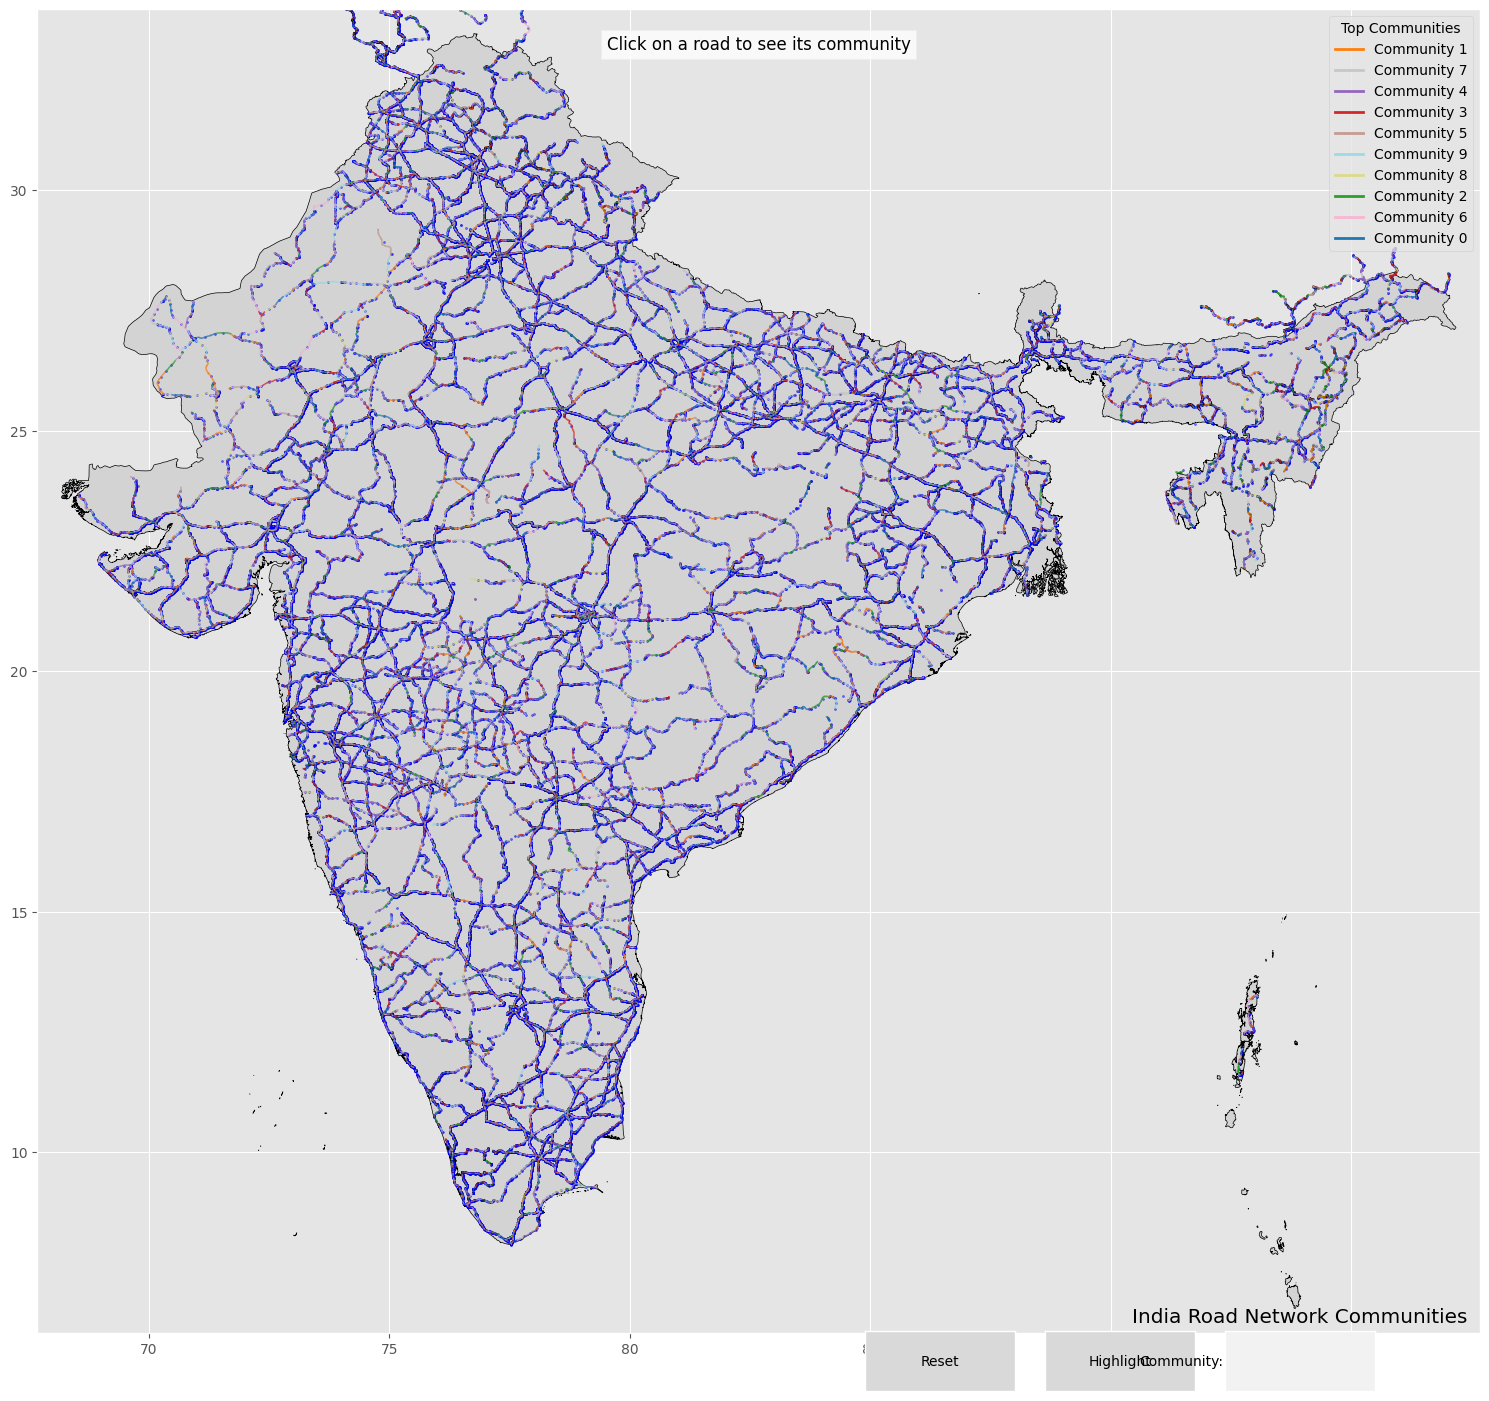

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
from matplotlib.widgets import Button, TextBox
import pandas as pd
import random
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# Assuming:
# - 'india' is a GeoDataFrame with India's boundary
# - 'GDF' is a GeoDataFrame with road geometries
# - We have community detection results to integrate

# Function to add communities to GDF
def add_communities_to_gdf(gdf, communities):
    """
    Add community assignments to the GeoDataFrame

    Parameters:
    - gdf: GeoDataFrame with road network
    - communities: Community detection results (membership list)

    Returns:
    - GeoDataFrame with community column added
    """
    # Make a copy to avoid modifying the original
    gdf_with_communities = gdf.copy()

    # Add communities as a new column
    # Assuming communities.membership contains the community for each node
    # and nodes in GDF are in the same order as in the graph

    # Check if communities is a list or has .membership attribute
    if hasattr(communities, 'membership'):
        community_list = communities.membership
    else:
        community_list = communities

    # If the length matches, assign directly
    if len(community_list) == len(gdf):
        gdf_with_communities['community'] = community_list
    else:
        # Handle case where length differs (e.g., if communities were calculated on a different representation)
        print(f"Warning: Length mismatch between GDF ({len(gdf)}) and communities ({len(community_list)})")
        # Assign default communities or handle error appropriately
        gdf_with_communities['community'] = -1

    return gdf_with_communities

# Function to create a colormap for communities
def get_community_colors(communities, cmap_name='tab20'):
    """
    Generate colors for each community using a colormap

    Parameters:
    - communities: List of community assignments or number of unique communities
    - cmap_name: Matplotlib colormap name

    Returns:
    - Dictionary mapping community IDs to colors
    """
    if isinstance(communities, (list, np.ndarray)):
        unique_communities = sorted(set(communities))
        n_communities = len(unique_communities)
    else:
        n_communities = communities
        unique_communities = range(n_communities)

    # Use a colormap with enough colors
    if n_communities <= 20:
        cmap = plt.cm.get_cmap(cmap_name, n_communities)
    else:
        # For many communities, generate random colors
        colors = [f"#{random.randint(0, 0xFFFFFF):06x}" for _ in range(n_communities)]
        return {comm_id: colors[i] for i, comm_id in enumerate(unique_communities)}

    return {comm_id: cmap(i) for i, comm_id in enumerate(unique_communities)}

# Create the interactive plot
def plot_interactive_communities(india_gdf, roads_gdf, communities=None, figsize=(15, 15)):
    """
    Create an interactive plot of road communities on India's map

    Parameters:
    - india_gdf: GeoDataFrame with India boundary
    - roads_gdf: GeoDataFrame with road network
    - communities: Community detection results (optional)
    - figsize: Figure size tuple
    """
    # Add communities to GDF if provided
    if communities:
        roads_gdf = add_communities_to_gdf(roads_gdf, communities)
    elif 'community' not in roads_gdf.columns:
        # If no communities provided and not in GDF, add dummy communities
        roads_gdf['community'] = np.zeros(len(roads_gdf), dtype=int)

    # Get community colors
    community_colors = get_community_colors(roads_gdf['community'].values)

    # Create figure and axes
    fig, ax = plt.subplots(figsize=figsize)

    # Plot India boundary
    gpd.GeoSeries([india_gdf.geometry.iloc[0]]).plot(ax=ax, color='lightgray', edgecolor='black')

    # Create line segments with colors based on communities
    lines = []
    colors = []
    for idx, row in roads_gdf.iterrows():
        # Get coordinates of the LineString
        if row.geometry.geom_type == 'LineString':
            coords = list(row.geometry.coords)
            for i in range(len(coords)-1):
                lines.append([(coords[i][0], coords[i][1]), (coords[i+1][0], coords[i+1][1])])
                colors.append(community_colors.get(row['community'], 'gray'))
        elif row.geometry.geom_type == 'MultiLineString':
            for line in row.geometry.geoms:
                coords = list(line.coords)
                for i in range(len(coords)-1):
                    lines.append([(coords[i][0], coords[i][1]), (coords[i+1][0], coords[i+1][1])])
                    colors.append(community_colors.get(row['community'], 'gray'))

    # Create a LineCollection for efficient plotting
    lc = LineCollection(lines, colors=colors, linewidths=1)
    line_collection = ax.add_collection(lc)

    # Create a dict to store road information for click events
    road_dict = {}
    for idx, row in roads_gdf.iterrows():
        centroid = row.geometry.centroid
        road_dict[(centroid.x, centroid.y)] = {
            'id': idx,
            'community': row['community'],
            'geometry': row.geometry
        }

    # Add road centroids for clicking
    centroids = roads_gdf.geometry.centroid
    scatter = ax.scatter(centroids.x, centroids.y, color='blue', s=2, alpha=0.5, picker=5)

    # Add info text box
    info_text = ax.text(0.02, 0.02, "", transform=ax.transAxes,
                        bbox=dict(facecolor='white', alpha=0.8),
                        fontsize=10, verticalalignment='bottom')

    # Create a legend for community colors (limit to top 10 for clarity)
    top_communities = roads_gdf['community'].value_counts().nlargest(10).index
    legend_elements = []
    for comm in top_communities:
        legend_elements.append(Line2D([0], [0], color=community_colors[comm], lw=2,
                                     label=f'Community {comm}'))
    ax.legend(handles=legend_elements, loc='upper right', title="Top Communities")

    # Status display
    status_text = ax.text(0.5, 0.98, "Click on a road to see its community",
                          transform=ax.transAxes,
                          fontsize=12, ha='center', va='top',
                          bbox=dict(facecolor='white', alpha=0.8))

    # Highlight community button
    highlight_ax = plt.axes([0.7, 0.02, 0.1, 0.04])
    highlight_button = Button(highlight_ax, 'Highlight')

    # Community input
    community_input_ax = plt.axes([0.82, 0.02, 0.1, 0.04])
    community_textbox = TextBox(community_input_ax, 'Community:', initial='')
    current_highlighted = {'community': None}

    # Handler for clicking on roads
    def on_pick(event):
        ind = event.ind[0]  # Get the index of the picked point
        x, y = centroids.iloc[ind].x, centroids.iloc[ind].y

        # Find the closest road in our dictionary
        nearest = min(road_dict.keys(), key=lambda coords: ((coords[0]-x)**2 + (coords[1]-y)**2))
        road_info = road_dict[nearest]

        info_text.set_text(f"Road ID: {road_info['id']}\nCommunity: {road_info['community']}")
        community_textbox.set_val(str(road_info['community']))

        fig.canvas.draw_idle()

    # Handler for highlighting a community
    def highlight_community(event):
        try:
            comm_to_highlight = int(community_textbox.text)

            # Reset previous colors if we had a highlight
            if current_highlighted['community'] is not None:
                new_colors = []
                for idx, row in roads_gdf.iterrows():
                    new_colors.append(community_colors.get(row['community'], 'gray'))
                lc.set_color(new_colors)

            # If highlighting the same community again, just remove highlight
            if current_highlighted['community'] == comm_to_highlight:
                current_highlighted['community'] = None
                status_text.set_text("Highlight removed")
            else:
                # Highlight selected community
                highlight_colors = []
                for idx, row in roads_gdf.iterrows():
                    if row['community'] == comm_to_highlight:
                        highlight_colors.append('red')  # Highlighted community
                    else:
                        highlight_colors.append('lightgray')  # Other communities (muted)

                lc.set_color(highlight_colors)
                current_highlighted['community'] = comm_to_highlight
                status_text.set_text(f"Community {comm_to_highlight} highlighted")

            fig.canvas.draw_idle()

        except ValueError:
            status_text.set_text("Please enter a valid community number")
            fig.canvas.draw_idle()

    # Connect events
    fig.canvas.mpl_connect('pick_event', on_pick)
    highlight_button.on_clicked(highlight_community)

    # Adjust plot limits
    ax.set_aspect('equal')
    bounds = india_gdf.geometry.bounds
    ax.set_xlim(bounds.iloc[0].minx - 0.5, bounds.iloc[0].maxx + 0.5)
    ax.set_ylim(bounds.iloc[0].miny - 0.5, bounds.iloc[0].maxy + 0.5)

    plt.title("India Road Network Communities")
    plt.tight_layout()

    # Function to reset the plot (can be triggered by a button)
    def reset_plot(event=None):
        # Reset colors to original community colors
        new_colors = []
        for idx, row in roads_gdf.iterrows():
            new_colors.append(community_colors.get(row['community'], 'gray'))
        lc.set_color(new_colors)

        current_highlighted['community'] = None
        info_text.set_text("")
        status_text.set_text("Click on a road to see its community")
        community_textbox.set_val("")

        fig.canvas.draw_idle()

    # Add reset button
    reset_ax = plt.axes([0.58, 0.02, 0.1, 0.04])
    reset_button = Button(reset_ax, 'Reset')
    reset_button.on_clicked(reset_plot)

    # Make sure the legend stays on top
    ax.legend(handles=legend_elements, loc='upper right', title="Top Communities")

    return fig, ax

# Function to save community assignments from detection algorithms to GDF
def save_communities_to_gdf(roads_gdf, communities, output_file):
    """
    Save community assignments to a new GeoDataFrame file

    Parameters:
    - roads_gdf: Original roads GeoDataFrame
    - communities: Community detection results
    - output_file: File path to save the enhanced GDF
    """
    roads_with_comm = add_communities_to_gdf(roads_gdf, communities)
    roads_with_comm.to_file(output_file)
    print(f"Saved roads with communities to {output_file}")
    return roads_with_comm

# Example usage:
"""
# If you have just performed community detection and have the results:
communities = detect_communities_louvain(GRAPH)  # or any other method

# Add to GDF and save
roads_with_communities = save_communities_to_gdf(GDF, communities, "india_roads_with_communities.gpkg")

# Create interactive plot
fig, ax = plot_interactive_communities(india, roads_with_communities)
plt.show()
"""

# Alternative usage if communities are already in GDF:
"""
# GDF already has 'community' column
fig, ax = plot_interactive_communities(india, GDF)
plt.show()
"""

# For demonstration, simulate community detection if not available:
if 'community' not in GDF.columns:
    print("Adding simulated communities for demonstration")
    # Assign random communities (0-9) for demonstration purposes
    GDF['community'] = np.random.randint(0, 10, size=len(GDF))

# Create the interactive visualization
fig, ax = plot_interactive_communities(india, GDF)
plt.show()

In [41]:
!pip install contextily

Loaded betweenness values from .npy file.


<ipython-input-42-4a81056a1a0d>:171: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0.03,1,0.97])


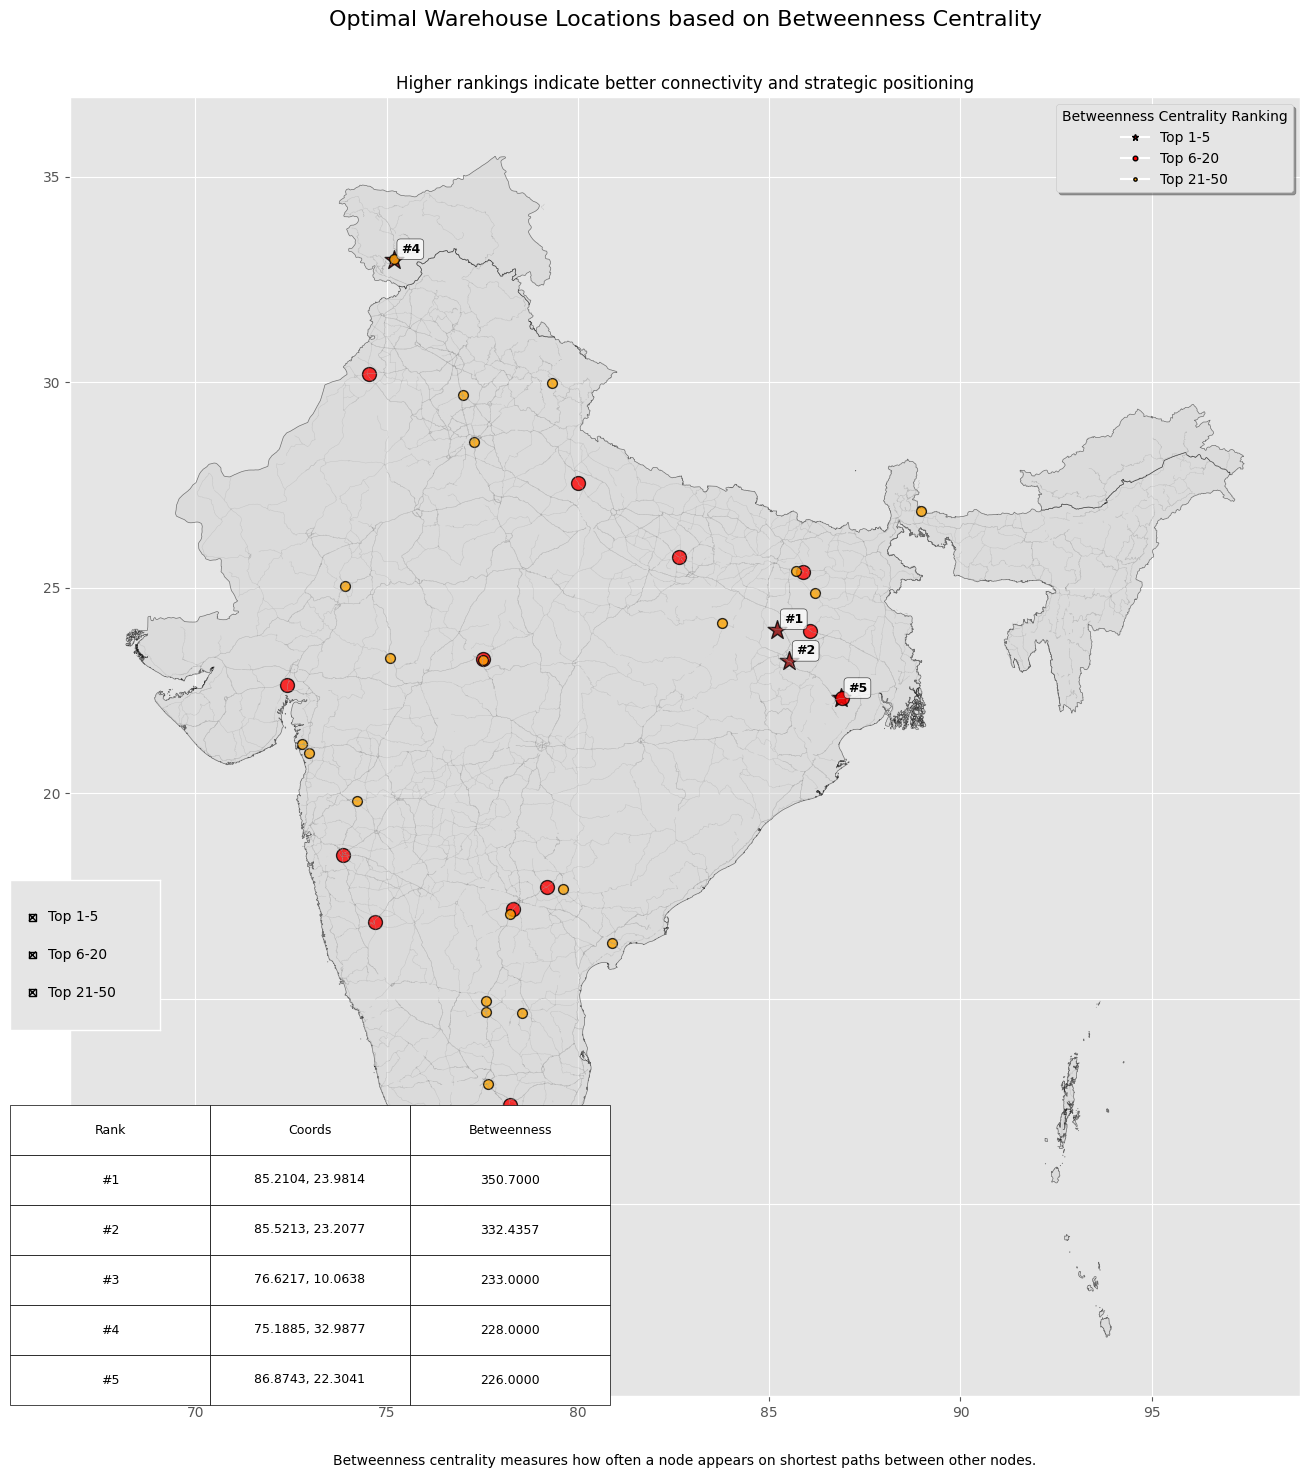

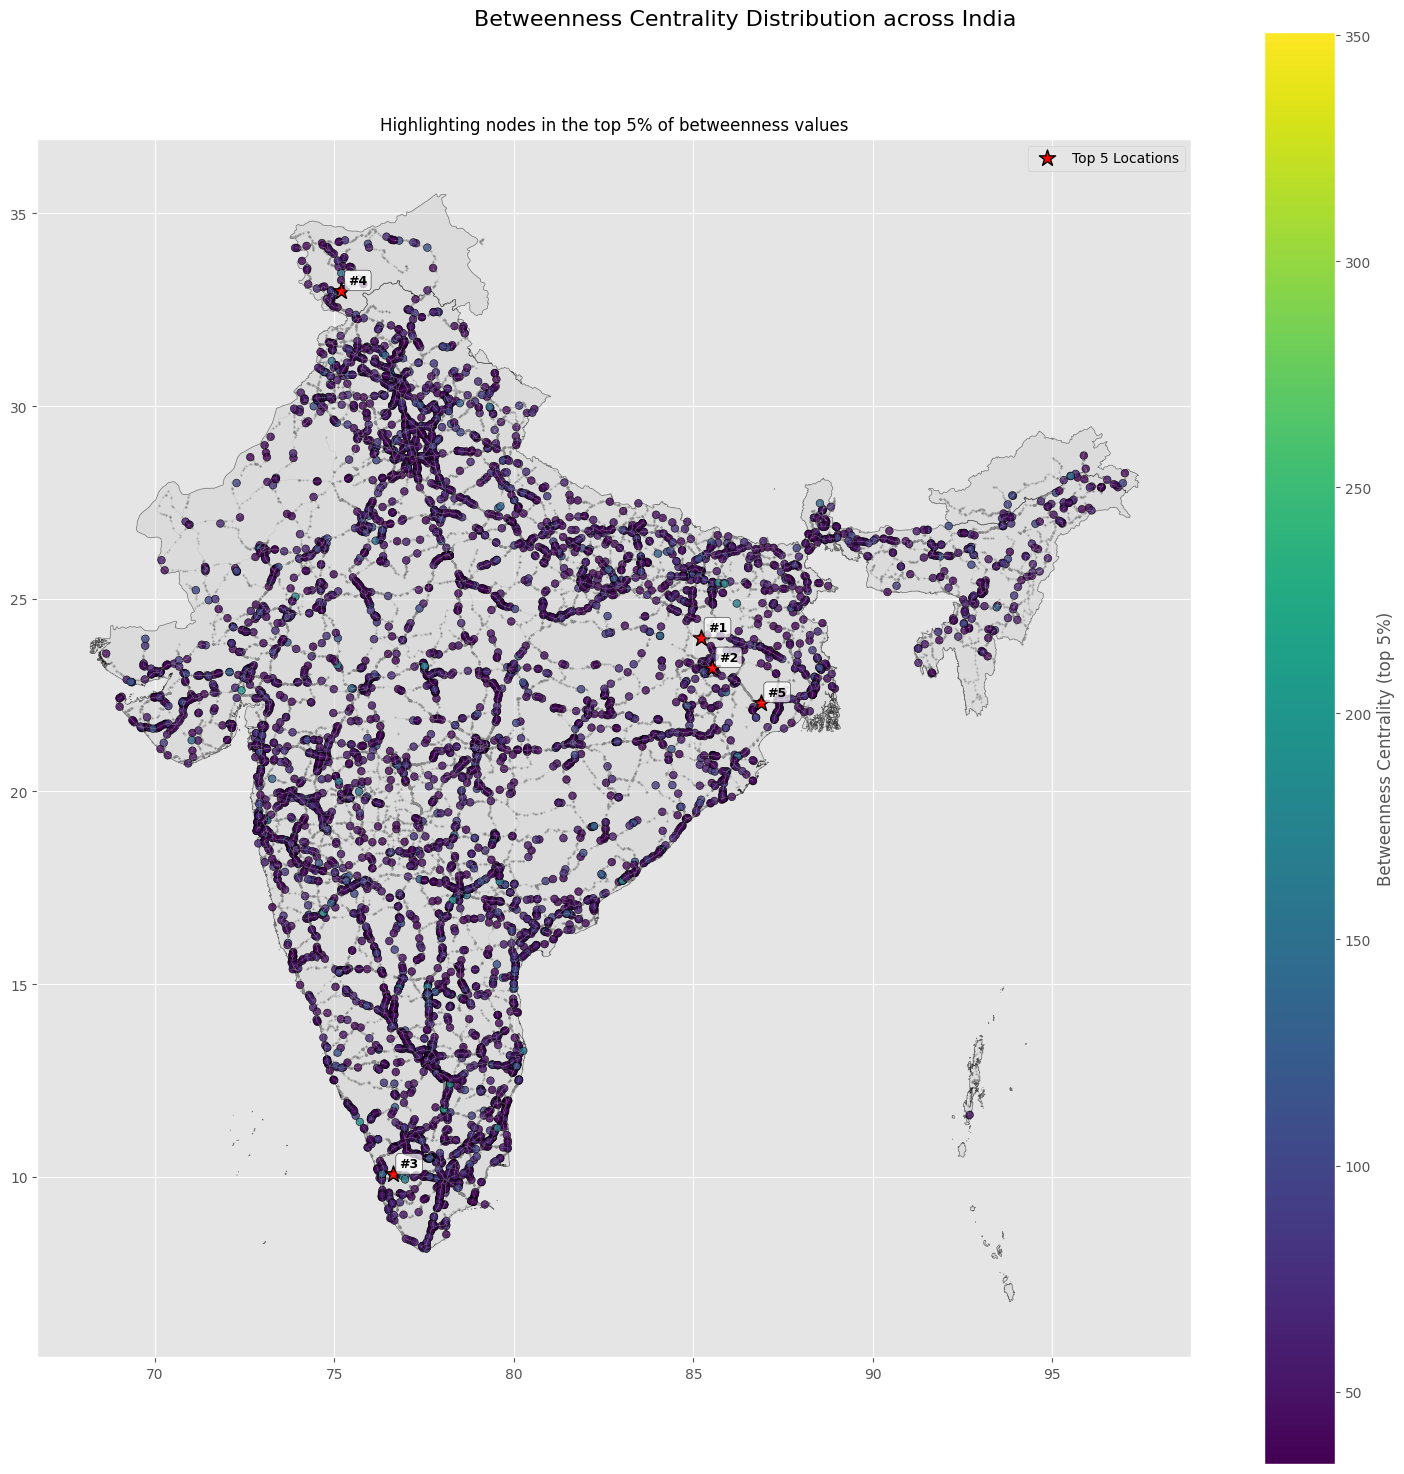


Top 10 Recommended Warehouse Locations:
        Rank  Location ID  Longitude   Latitude  Betweenness Score  \
70188      1        70188  85.210410  23.981432           350.7000   
97891      2        97891  85.521314  23.207717           332.4357   
82706      3        82706  76.621698  10.063822           233.0000   
96474      4        96474  75.188488  32.987682           228.0000   
76679      5        76679  86.874251  22.304078           226.0000   
84643      6        84643  78.050801  11.754784           223.0000   
55727      7        55727  79.185523  17.710206           214.1667   
108351     8       108351  82.637959  25.752274           213.2167   
92379      9        92379  74.690479  16.851544           203.5000   
100283    10       100283  72.411213  22.621765           199.0000   

        Normalized Score (0-100)  
70188                     100.00  
97891                      94.79  
82706                      66.44  
96474                      65.01  
76679        

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import pandas as pd
import contextily as ctx
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.patches as mpatches
from shapely.geometry import Point
import os
from matplotlib.widgets import CheckButtons

# Function to create node GeoDataFrame from road network
def create_node_gdf(road_gdf):
    """
    Extract nodes from road network and create a GeoDataFrame

    Parameters:
    - road_gdf: GeoDataFrame with road geometries

    Returns:
    - GeoDataFrame with nodes
    """
    nodes = []
    node_ids = {}
    node_count = 0

    for _, road in road_gdf.iterrows():
        geoms = [road.geometry] if road.geometry.geom_type == 'LineString' else road.geometry.geoms
        for line in geoms:
            start_point = Point(line.coords[0])
            end_point = Point(line.coords[-1])

            # Add start point if new
            start_str = f"{start_point.x:.6f},{start_point.y:.6f}"
            if start_str not in node_ids:
                node_ids[start_str] = node_count
                nodes.append({'node_id': node_count, 'geometry': start_point})
                node_count += 1

            # Add end point if new
            end_str = f"{end_point.x:.6f},{end_point.y:.6f}"
            if end_str not in node_ids:
                node_ids[end_str] = node_count
                nodes.append({'node_id': node_count, 'geometry': end_point})
                node_count += 1

    node_gdf = gpd.GeoDataFrame(nodes, crs=road_gdf.crs)
    return node_gdf

# Function to add betweenness centrality to node GeoDataFrame
def add_betweenness_to_nodes(node_gdf, betweenness_values):
    """
    Add betweenness centrality values to node GeoDataFrame
    """
    node_gdf = node_gdf.copy()
    if len(betweenness_values) == len(node_gdf):
        node_gdf['betweenness'] = betweenness_values
    else:
        print(f"Warning: Length mismatch between node_gdf ({len(node_gdf)}) and betweenness values ({len(betweenness_values)})")
        if len(betweenness_values) > len(node_gdf):
            node_gdf['betweenness'] = betweenness_values[:len(node_gdf)]
        else:
            padded = list(betweenness_values) + [0] * (len(node_gdf) - len(betweenness_values))
            node_gdf['betweenness'] = padded
    node_gdf['rank'] = node_gdf['betweenness'].rank(ascending=False)
    return node_gdf

# Function to create a warehouse location analysis visualization
def plot_warehouse_locations(india_gdf, road_gdf, node_gdf=None, betweenness_values=None,
                            figsize=(15, 15), top_n=50, use_basemap=True):
    """
    Create a visualization of optimal warehouse locations based on betweenness centrality
    """
    if node_gdf is None:
        node_gdf = create_node_gdf(road_gdf)
    if betweenness_values is not None:
        node_gdf = add_betweenness_to_nodes(node_gdf, betweenness_values)
    elif 'betweenness' not in node_gdf:
        if os.path.exists('betweenness_values.npy'):
            try:
                vals = np.load('betweenness_values.npy')
                node_gdf = add_betweenness_to_nodes(node_gdf, vals)
            except Exception:
                node_gdf['betweenness'] = np.random.exponential(scale=1.0, size=len(node_gdf))
                node_gdf['rank'] = node_gdf['betweenness'].rank(ascending=False)
        else:
            node_gdf['betweenness'] = np.random.exponential(scale=1.0, size=len(node_gdf))
            node_gdf['rank'] = node_gdf['betweenness'].rank(ascending=False)

    fig, ax = plt.subplots(figsize=figsize)
    india_gdf.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)
    road_gdf.plot(ax=ax, linewidth=0.3, color='darkgray', alpha=0.5)

    top_nodes = node_gdf.sort_values('betweenness', ascending=False).head(top_n)

    # Define categories with explicit bounds
    rank_categories = [
        {'name': 'Top 1-5',   'min_rank': 1,   'max_rank': 5,  'color': 'darkred', 'marker': '*', 'size': 200},
        {'name': 'Top 6-20',  'min_rank': 6,   'max_rank': 20, 'color': 'red',     'marker': 'o', 'size': 100},
        {'name': 'Top 21-50', 'min_rank': 21,  'max_rank': 50, 'color': 'orange',  'marker': 'o', 'size': 50}
    ]

    for category in rank_categories:
        mask = (
            (top_nodes['rank'] >= category['min_rank']) &
            (top_nodes['rank'] <= category['max_rank'])
        )
        cat_nodes = top_nodes[mask]
        ax.scatter(
            cat_nodes.geometry.x,
            cat_nodes.geometry.y,
            s=category['size'], c=category['color'], marker=category['marker'],
            edgecolor='black', linewidth=1, alpha=0.8, label=category['name']
        )
        if category['min_rank'] == 1:
            for _, row in cat_nodes.iterrows():
                ax.annotate(
                    f"#{int(row['rank'])}", xy=(row.geometry.x, row.geometry.y),
                    xytext=(5, 5), textcoords="offset points",
                    fontsize=9, fontweight='bold', color='black',
                    bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='black', alpha=0.7)
                )

    legend_elems = [plt.Line2D([0],[0], marker=cat['marker'], color='w',
                     markerfacecolor=cat['color'], markeredgecolor='black',
                     markersize=np.sqrt(cat['size'])/3, label=cat['name'])
                     for cat in rank_categories]
    ax.legend(handles=legend_elems, title="Betweenness Centrality Ranking",
              loc='upper right', frameon=True, fancybox=True, shadow=True)

    if use_basemap:
        try:
            ctx.add_basemap(ax, crs=india_gdf.crs.to_string())
        except Exception:
            print("Could not add basemap. Install contextily to enable basemaps.")

    # Table of top 5
    top5 = top_nodes.head(5).copy()
    top5['Rank'] = top5['rank'].astype(int)
    table_data = [[f"#{r}", f"{x:.4f}, {y:.4f}", f"{s:.4f}" ]
                  for r, x, y, s in zip(top5['Rank'], top5.geometry.x, top5.geometry.y, top5['betweenness'])]
    tbl_ax = plt.axes([0.05,0.05,0.4,0.2])
    tbl = plt.table(cellText=table_data, colLabels=['Rank','Coords','Betweenness'],
                    loc='center', cellLoc='center', bbox=[0,0,1,1])
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9)
    tbl.scale(1,1.5)
    tbl_ax.axis('off')

    # Checkboxes
    chk_ax = plt.axes([0.05,0.3,0.1,0.1], frameon=True)
    chk = CheckButtons(chk_ax, [cat['name'] for cat in rank_categories], [True]*len(rank_categories))
    def toggle(label):
        for cat in rank_categories:
            if cat['name']==label:
                m = ((top_nodes['rank']>=cat['min_rank'])&(top_nodes['rank']<=cat['max_rank']))
                for c in ax.collections:
                    if c.get_label()==label:
                        c.set_visible(not c.get_visible()); break
        fig.canvas.draw_idle()
    chk.on_clicked(toggle)

    plt.suptitle("Optimal Warehouse Locations based on Betweenness Centrality", fontsize=16)
    ax.set_title("Higher rankings indicate better connectivity and strategic positioning", fontsize=12)
    plt.figtext(0.5,0.01,
        "Betweenness centrality measures how often a node appears on shortest paths between other nodes.",
        wrap=True, ha='center', fontsize=10)
    plt.tight_layout(rect=[0,0.03,1,0.97])
    return fig, ax, top_nodes

# (plot_betweenness_gradient and generate_location_report remain unchanged)
def plot_betweenness_gradient(india_gdf, road_gdf, node_gdf=None, betweenness_values=None,
                               figsize=(15, 15), percentile_threshold=90):
    if node_gdf is None:
        node_gdf = create_node_gdf(road_gdf)
    if betweenness_values is not None:
        node_gdf = add_betweenness_to_nodes(node_gdf, betweenness_values)
    elif 'betweenness' not in node_gdf:
        if os.path.exists('betweenness_values.npy'):
            try:
                vals = np.load('betweenness_values.npy')
                node_gdf = add_betweenness_to_nodes(node_gdf, vals)
            except Exception:
                node_gdf['betweenness'] = np.random.exponential(scale=1.0, size=len(node_gdf))
                node_gdf['rank'] = node_gdf['betweenness'].rank(ascending=False)
        else:
            node_gdf['betweenness'] = np.random.exponential(scale=1.0, size=len(node_gdf))
            node_gdf['rank'] = node_gdf['betweenness'].rank(ascending=False)

    fig, ax = plt.subplots(figsize=figsize)
    india_gdf.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)
    road_gdf.plot(ax=ax, linewidth=0.3, color='darkgray', alpha=0.5)

    high_thresh = np.percentile(node_gdf['betweenness'], percentile_threshold)
    ax.scatter(node_gdf.geometry.x, node_gdf.geometry.y, s=1, c='gray', alpha=0.3)
    high_nodes = node_gdf[node_gdf['betweenness']>=high_thresh]
    norm = Normalize(vmin=high_thresh, vmax=node_gdf['betweenness'].max())
    sm = ScalarMappable(norm=norm, cmap=plt.cm.viridis)
    scat = ax.scatter(high_nodes.geometry.x, high_nodes.geometry.y,
                      s=30, c=high_nodes['betweenness'], cmap=plt.cm.viridis,
                      norm=norm, edgecolor='black', linewidth=0.5, alpha=0.8)
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label(f'Betweenness Centrality (top {100-percentile_threshold}%)')

    top5 = node_gdf.sort_values('betweenness', ascending=False).head(5)
    ax.scatter(top5.geometry.x, top5.geometry.y, s=150, c='red', marker='*',
               edgecolor='black', linewidth=1, label='Top 5 Locations')
    for _, row in top5.iterrows():
        ax.annotate(f"#{int(row['rank'])}",
                    xy=(row.geometry.x, row.geometry.y), xytext=(5,5),
                    textcoords='offset points', fontsize=9, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='black', alpha=0.7))
    ax.legend(loc='upper right')
    plt.suptitle("Betweenness Centrality Distribution across India", fontsize=16)
    ax.set_title(f"Highlighting nodes in the top {100-percentile_threshold}% of betweenness values", fontsize=12)
    plt.tight_layout()
    return fig, ax


def generate_location_report(node_gdf, top_n=10):
    if 'betweenness' not in node_gdf:
        print("Error: Node GeoDataFrame lacks betweenness values.")
        return None
    top = node_gdf.sort_values('betweenness', ascending=False).head(top_n).copy()
    max_b = node_gdf['betweenness'].max()
    top['normalized'] = (top['betweenness']/max_b)*100
    report = pd.DataFrame({
        'Rank': range(1, top_n+1),
        'Location ID': top['node_id'],
        'Longitude': top.geometry.x.round(6),
        'Latitude': top.geometry.y.round(6),
        'Betweenness Score': top['betweenness'].round(4),
        'Normalized Score (0-100)': top['normalized'].round(2)
    })
    return report

# ----- Main Execution -----
try:
    betweenness_values = np.load('betweenness_values.npy')
    print("Loaded betweenness values from .npy file.")
except FileNotFoundError:
    print("betweenness_values.npy not found; generating random demo values.")
    betweenness_values = np.random.exponential(scale=1.0, size=100000)

# Assuming GDF and india are pre-loaded GeoDataFrames
node_gdf = create_node_gdf(GDF)
node_gdf = add_betweenness_to_nodes(node_gdf, betweenness_values)

fig1, ax1, top_nodes = plot_warehouse_locations(india, GDF, node_gdf=node_gdf,
                                                 betweenness_values=None, use_basemap=False)
plt.savefig("optimal_warehouse_locations.png", dpi=300, bbox_inches='tight')
plt.show()
68
fig2, ax2 = plot_betweenness_gradient(india, GDF, node_gdf=node_gdf,
                                       betweenness_values=None, percentile_threshold=95)
plt.savefig("betweenness_distribution_map.png", dpi=300, bbox_inches='tight')
plt.show()

report = generate_location_report(node_gdf, top_n=10)
print("\nTop 10 Recommended Warehouse Locations:")
print(report)
report.to_csv("warehouse_location_recommendations.csv", index=False)
print("Saved recommendations to CSV.")



=== Analyzing Hub Nodes in Communities ===
Loading pre-computed betweenness values...
Loaded betweenness values for 116571 nodes

=== Visualizing Communities with Hub Nodes from louvain ===
Graph too large for full visualization. Sampling 1000 nodes...
Created subgraph with 1000 nodes and 14 edges
Calculating graph layout...
Error during visualization: 'maxiter' is an invalid keyword argument for this function

=== Analyzing Hub Node Properties ===

Top Hub Nodes:
       Node  Community  Betweenness  Degree  Connected Communities  Comm Size  \
49    70188         49   350.700000      20                      1       3182   
1     97891          2   332.435714       8                      1       3782   
25    82706         26   233.000000       5                      1       4829   
23    96474         24   228.000000       6                      1       4059   
14    76679          3   226.000000       7                      1       5672   
22    84643         23   223.000000       6 

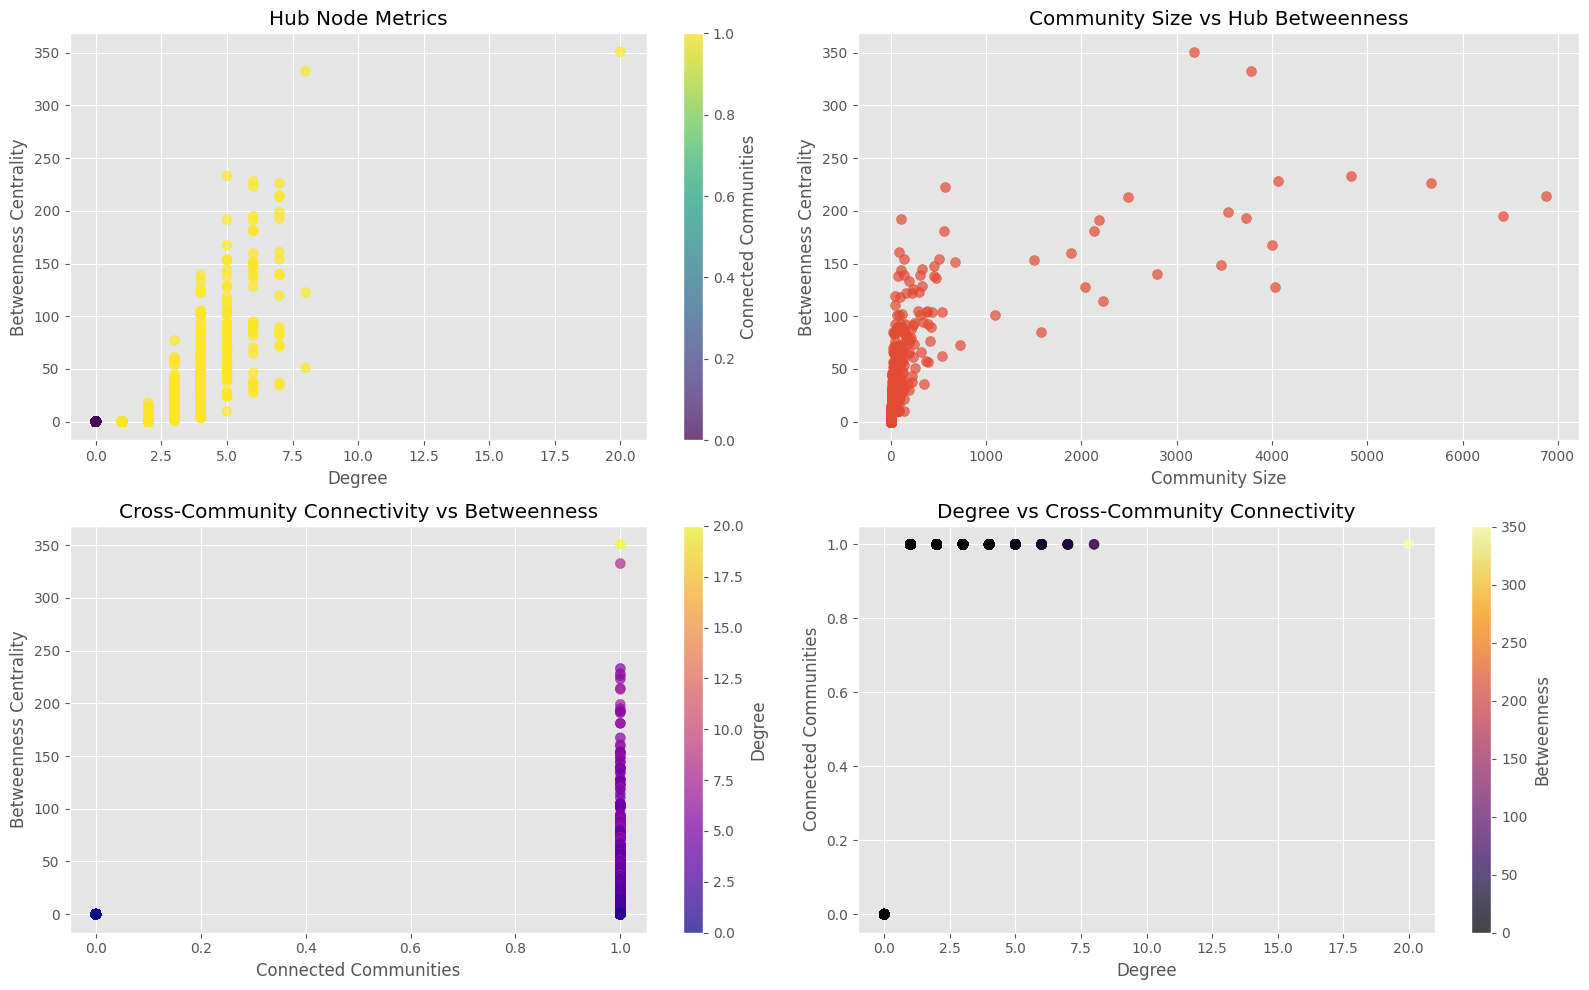

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict, Counter
import igraph as ig
import random
import os
import gc

# Load betweenness values if they exist, otherwise compute them
def get_betweenness_values(graph, cutoff=5):
    """Load or compute betweenness centrality values"""
    if os.path.exists("betweenness_values.npy"):
        print("Loading pre-computed betweenness values...")
        betweenness_values = np.load("betweenness_values.npy")
        print(f"Loaded betweenness values for {len(betweenness_values)} nodes")
    else:
        # Use a simpler method for initial visualization
        print("Computing betweenness centrality (this may take a while)...")
        print(f"Using path length cutoff of {cutoff}")

        # For speed during development, use a path length cutoff and vertex subset
        sample_size = min(5000, graph.vcount())

        if graph.vcount() > 10000:
            print(f"Large graph detected. Using approximate betweenness with {sample_size} samples...")
            betweenness_values = graph.betweenness(
                vertices=None,
                directed=False,
                cutoff=cutoff,  # Limit path length
                weights=None,
                nobigint=True,
                samples=sample_size  # Use sampling for very large graphs
            )
        else:
            betweenness_values = graph.betweenness(
                vertices=None,
                directed=False,
                cutoff=cutoff,  # Limit path length
                weights=None
            )

        np.save("betweenness_values.npy", betweenness_values)
        print("Betweenness values computed and saved")

    return betweenness_values

# Function to find the nodes with highest betweenness in each community
def get_top_nodes_per_community(graph, communities, betweenness_values, top_n=1):
    """Identify top nodes by betweenness in each community"""
    # Create a mapping of community to nodes
    community_nodes = defaultdict(list)
    for node_idx, comm_idx in enumerate(communities.membership):
        community_nodes[comm_idx].append(node_idx)

    # Find top nodes for each community
    top_nodes = {}
    for comm_idx, nodes in community_nodes.items():
        # Get betweenness values for nodes in this community
        comm_betweenness = [(node, betweenness_values[node]) for node in nodes]
        # Sort by betweenness (descending)
        sorted_nodes = sorted(comm_betweenness, key=lambda x: x[1], reverse=True)
        # Take top N nodes
        top_nodes[comm_idx] = sorted_nodes[:top_n]

    return top_nodes

# Function to visualize communities with hub nodes highlighted
def visualize_communities_with_hubs(graph, communities, algorithm_name,
                                   betweenness_values, max_nodes=1000):
    """Visualize community structure with top betweenness nodes highlighted"""
    print(f"\n=== Visualizing Communities with Hub Nodes from {algorithm_name} ===")

    # For large graphs, sample nodes
    if graph.vcount() > max_nodes:
        print(f"Graph too large for full visualization. Sampling {max_nodes} nodes...")

        # Sample nodes while preserving community proportions
        community_counts = Counter(communities.membership)
        sampled_nodes = []

        # Calculate how many nodes to sample from each community
        total_nodes = graph.vcount()
        for comm_id, count in community_counts.items():
            # Proportional sampling
            sample_size = int((count / total_nodes) * max_nodes)
            # Get all nodes in this community
            comm_nodes = [i for i, c in enumerate(communities.membership) if c == comm_id]
            # Sample from this community
            sampled_from_comm = random.sample(comm_nodes, min(sample_size, len(comm_nodes)))
            sampled_nodes.extend(sampled_from_comm)

        # If we didn't get enough samples, add more randomly
        if len(sampled_nodes) < max_nodes:
            remaining = max_nodes - len(sampled_nodes)
            eligible = list(set(range(graph.vcount())) - set(sampled_nodes))
            if eligible:
                additional = random.sample(eligible, min(remaining, len(eligible)))
                sampled_nodes.extend(additional)

        # Create subgraph
        subgraph = graph.subgraph(sampled_nodes)

        # Map community memberships to subgraph
        subgraph_communities = [communities.membership[i] for i in sampled_nodes]

        # Map original vertex indices to subgraph indices
        orig_to_sub = {orig: sub_idx for sub_idx, orig in enumerate(sampled_nodes)}

        # Map betweenness values to subgraph nodes
        subgraph_betweenness = [betweenness_values[i] for i in sampled_nodes]

        print(f"Created subgraph with {subgraph.vcount()} nodes and {subgraph.ecount()} edges")
    else:
        # Use the full graph
        subgraph = graph
        subgraph_communities = communities.membership
        sampled_nodes = list(range(graph.vcount()))
        orig_to_sub = {i: i for i in range(graph.vcount())}
        subgraph_betweenness = betweenness_values

    try:
        # Get top nodes in each community
        all_top_nodes = get_top_nodes_per_community(graph, communities, betweenness_values)

        # Filter to only include top nodes that are in our sampled subgraph
        top_nodes_in_subgraph = {}
        for comm_id, top_nodes in all_top_nodes.items():
            nodes_in_subgraph = []
            for node, betw in top_nodes:
                if node in orig_to_sub:
                    nodes_in_subgraph.append((orig_to_sub[node], betw))
            if nodes_in_subgraph:
                top_nodes_in_subgraph[comm_id] = nodes_in_subgraph

        # Calculate layout
        print("Calculating graph layout...")
        layout = subgraph.layout_fruchterman_reingold(
            weights=None,
            maxiter=500,
            area=subgraph.vcount()*(subgraph.vcount()),
            repulserad=subgraph.vcount()*subgraph.vcount()
        )

        # Get unique communities and assign colors
        unique_communities = sorted(set(subgraph_communities))
        community_colors = plt.cm.tab20(np.linspace(0, 1, len(unique_communities)))
        color_map = {comm: community_colors[i] for i, comm in enumerate(unique_communities)}

        # Create node colors list
        node_colors = [color_map[comm] for comm in subgraph_communities]

        # Create node sizes based on betweenness (normalize to reasonable size range)
        if max(subgraph_betweenness) > 0:
            node_sizes = [20 + (b / max(subgraph_betweenness)) * 100 for b in subgraph_betweenness]
        else:
            node_sizes = [20] * len(subgraph_betweenness)

        # Mark hub nodes with larger size
        hub_nodes = set()
        for comm_id, nodes in top_nodes_in_subgraph.items():
            for node_idx, _ in nodes:
                hub_nodes.add(node_idx)
                # Make hub nodes much larger
                node_sizes[node_idx] = 200

        # Create visualization
        plt.figure(figsize=(20, 20))

        # Extract coordinates
        xs = [coord[0] for coord in layout]
        ys = [coord[1] for coord in layout]

        # Plot edges
        for edge in subgraph.get_edgelist():
            plt.plot([xs[edge[0]], xs[edge[1]]], [ys[edge[0]], ys[edge[1]]], 'gray', alpha=0.2, linewidth=0.5)

        # Plot regular nodes
        regular_nodes = set(range(len(xs))) - hub_nodes
        plt.scatter(
            [xs[i] for i in regular_nodes],
            [ys[i] for i in regular_nodes],
            c=[node_colors[i] for i in regular_nodes],
            s=[node_sizes[i] for i in regular_nodes],
            alpha=0.7,
            edgecolors='black',
            linewidths=0.5
        )

        # Plot hub nodes with star markers
        if hub_nodes:
            plt.scatter(
                [xs[i] for i in hub_nodes],
                [ys[i] for i in hub_nodes],
                c=[node_colors[i] for i in hub_nodes],
                s=[node_sizes[i] for i in hub_nodes],
                alpha=1.0,
                marker='*',
                edgecolors='black',
                linewidths=1.5,
                zorder=10  # Ensure hub nodes are on top
            )

        # Create legend for the top communities
        # Limit to 10 for readability
        top_comms = Counter(subgraph_communities).most_common(10)
        for comm_id, count in top_comms:
            plt.scatter([], [], c=[color_map[comm_id]], s=50, label=f"Community {comm_id} ({count} nodes)")

        # Add legend entry for hub nodes
        plt.scatter([], [], s=200, marker='*', c='black', alpha=0.7, label=f"Hub Nodes (highest betweenness)")

        plt.legend(title="Communities and Hubs", loc='upper right', fontsize=12)

        plt.title(f'Community Structure with Hub Nodes\n{algorithm_name} ({len(unique_communities)} communities)', fontsize=16)
        plt.axis('off')
        plt.tight_layout()

        # Save with higher resolution
        plt.savefig(f"community_hubs_{algorithm_name}.png", dpi=300, bbox_inches='tight')
        print(f"Visualization saved to community_hubs_{algorithm_name}.png")

        # Generate detailed hub node information
        print("\n=== Top Hub Nodes by Community ===")
        top_hub_info = []
        for comm_id in sorted(all_top_nodes.keys()):
            if comm_id in top_nodes_in_subgraph:
                nodes_info = [(n, b) for n, b in all_top_nodes[comm_id]]
                comm_size = Counter(communities.membership)[comm_id]
                top_hub_info.append({
                    'Community': comm_id,
                    'Size': comm_size,
                    'Hub Node': nodes_info[0][0],
                    'Betweenness': nodes_info[0][1],
                    'Relative Importance': nodes_info[0][1] / max(betweenness_values) * 100
                })

        # Create and save hub information dataframe
        if top_hub_info:
            df_hubs = pd.DataFrame(top_hub_info)
            df_hubs = df_hubs.sort_values('Betweenness', ascending=False)
            print(df_hubs)

            # Save to CSV
            df_hubs.to_csv(f"community_hubs_{algorithm_name}.csv", index=False)
            print(f"Hub information saved to community_hubs_{algorithm_name}.csv")

            # Create a bar chart of hub nodes by community
            plt.figure(figsize=(14, 8))
            top_hubs = df_hubs.nlargest(15, 'Betweenness')

            # Plot bars colored by community
            bars = plt.bar(
                range(len(top_hubs)),
                top_hubs['Betweenness'],
                color=[color_map[comm] for comm in top_hubs['Community']]
            )

            # Add labels
            plt.xticks(
                range(len(top_hubs)),
                [f"C{row['Community']}\nN{row['Hub Node']}" for _, row in top_hubs.iterrows()],
                rotation=45,
                ha='right'
            )

            plt.title('Top Hub Nodes by Betweenness Centrality', fontsize=16)
            plt.ylabel('Betweenness Centrality')
            plt.xlabel('Community and Node ID')
            plt.tight_layout()
            plt.savefig(f"top_hubs_barchart_{algorithm_name}.png", dpi=300)
            print(f"Hub bar chart saved to top_hubs_barchart_{algorithm_name}.png")

    except Exception as e:
        print(f"Error during visualization: {str(e)}")


# Main function to plot best nodes per community
def plot_best_nodes_per_community(graph, communities=None, algorithm="louvain"):
    """Main function to analyze and visualize hub nodes in communities"""
    print(f"\n=== Analyzing Hub Nodes in Communities ===")

    # If no communities provided, run community detection
    if communities is None:
        print("No communities provided. Running Louvain community detection...")
        communities = graph.community_multilevel()
        print(f"Detected {len(set(communities.membership))} communities")

    # Get betweenness values
    betweenness_values = get_betweenness_values(graph)

    # Visualize communities with hub nodes
    visualize_communities_with_hubs(
        graph,
        communities,
        algorithm,
        betweenness_values
    )

    # Analyze hub nodes in more detail
    analyze_hub_nodes(graph, communities, betweenness_values)

    return communities, betweenness_values


def analyze_hub_nodes(graph, communities, betweenness_values):
    """Analyze structural properties of hub nodes"""
    print("\n=== Analyzing Hub Node Properties ===")

    # Get top nodes per community
    top_nodes = get_top_nodes_per_community(graph, communities, betweenness_values)

    # Collect hub node data
    hub_data = []
    for comm_id, nodes in top_nodes.items():
        for node_idx, betw in nodes:
            # Get node properties
            degree = graph.degree(node_idx)
            neighbors = graph.neighbors(node_idx)

            # Check how many communities this node connects to
            neighbor_communities = set()
            for neighbor in neighbors:
                neighbor_communities.add(communities.membership[neighbor])

            # Add data
            hub_data.append({
                'Node': node_idx,
                'Community': comm_id,
                'Betweenness': betw,
                'Degree': degree,
                'Connected Communities': len(neighbor_communities),
                'Comm Size': Counter(communities.membership)[comm_id]
            })

    # Create dataframe
    df_hubs = pd.DataFrame(hub_data)

    # Calculate additional metrics
    df_hubs['Relative Betweenness'] = df_hubs['Betweenness'] / max(betweenness_values) * 100
    df_hubs['Degree Centrality'] = df_hubs['Degree'] / (graph.vcount() - 1)

    # Sort by betweenness
    df_hubs = df_hubs.sort_values('Betweenness', ascending=False)

    # Display top hubs
    print("\nTop Hub Nodes:")
    print(df_hubs.head(15))

    # Save detailed hub information
    df_hubs.to_csv("hub_nodes_detailed.csv", index=False)
    print("Detailed hub node information saved to hub_nodes_detailed.csv")

    # Visualize relationship between hub metrics
    plt.figure(figsize=(16, 10))

    # Hub metrics correlation
    plt.subplot(2, 2, 1)
    plt.scatter(
        df_hubs['Degree'],
        df_hubs['Betweenness'],
        alpha=0.7,
        s=50,
        c=df_hubs['Connected Communities'],
        cmap='viridis'
    )
    plt.colorbar(label='Connected Communities')
    plt.xlabel('Degree')
    plt.ylabel('Betweenness Centrality')
    plt.title('Hub Node Metrics')

    # Community size vs hub betweenness
    plt.subplot(2, 2, 2)
    plt.scatter(
        df_hubs['Comm Size'],
        df_hubs['Betweenness'],
        alpha=0.7,
        s=50
    )
    plt.xlabel('Community Size')
    plt.ylabel('Betweenness Centrality')
    plt.title('Community Size vs Hub Betweenness')

    # Connected communities vs betweenness
    plt.subplot(2, 2, 3)
    plt.scatter(
        df_hubs['Connected Communities'],
        df_hubs['Betweenness'],
        alpha=0.7,
        s=50,
        c=df_hubs['Degree'],
        cmap='plasma'
    )
    plt.colorbar(label='Degree')
    plt.xlabel('Connected Communities')
    plt.ylabel('Betweenness Centrality')
    plt.title('Cross-Community Connectivity vs Betweenness')

    # Degree vs connected communities
    plt.subplot(2, 2, 4)
    plt.scatter(
        df_hubs['Degree'],
        df_hubs['Connected Communities'],
        alpha=0.7,
        s=50,
        c=df_hubs['Betweenness'],
        cmap='inferno'
    )
    plt.colorbar(label='Betweenness')
    plt.xlabel('Degree')
    plt.ylabel('Connected Communities')
    plt.title('Degree vs Cross-Community Connectivity')

    plt.tight_layout()
    plt.savefig("hub_node_analysis.png", dpi=300)
    print("Hub node analysis visualizations saved to hub_node_analysis.png")

    return df_hubs


# Run the analysis if a Louvain community detection has already been performed
if 'communities' in locals() or 'communities' in globals():
    plot_best_nodes_per_community(GRAPH, communities, "louvain")
else:
    # Run Louvain and analyze hub nodes
    communities, betweenness_values = plot_best_nodes_per_community(GRAPH)


=== Mapping Hub Nodes on India ===
Loading pre-computed betweenness values...
Loaded betweenness values for 116571 nodes
Calculating centroids for all nodes...
Extracted 116571 centroids

=== Plotting Hub Nodes on India Map ===
Calculating centroids for all nodes...
Extracted 116571 centroids
Map visualization saved to hub_nodes_india_map.png
Hub nodes data saved to hub_nodes.geojson

=== Top Hub Nodes Information ===
     node_id  community  betweenness  relative_betweenness  node_degree  \
49     70188         49   350.700000            100.000000           20   
1      97891          2   332.435714             94.792049            8   
25     82706         26   233.000000             66.438551            5   
23     96474         24   228.000000             65.012831            6   
14     76679          3   226.000000             64.442543            7   
22     84643         23   223.000000             63.587111            6   
0      55727          0   214.166667             61.

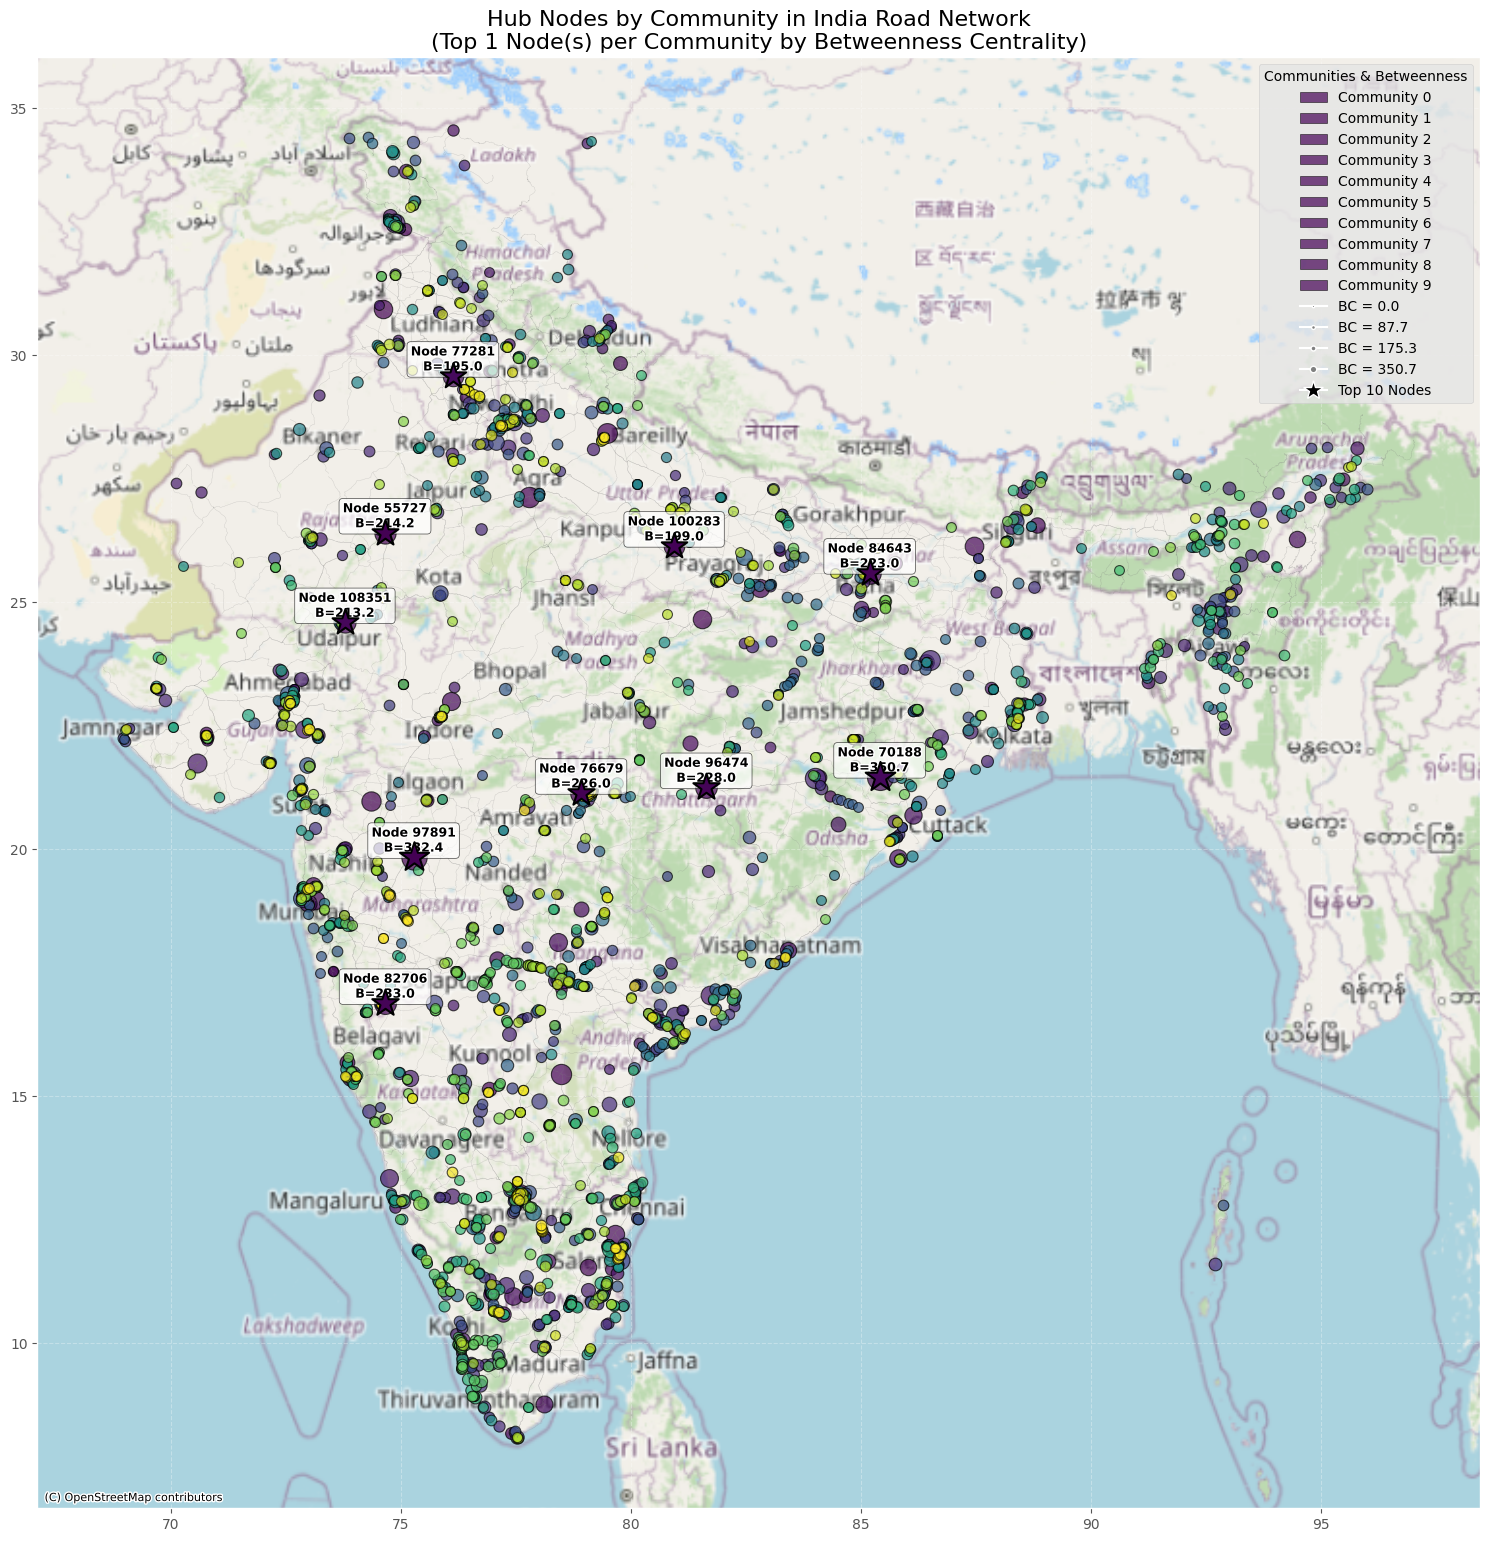

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import geopandas as gpd
from collections import defaultdict, Counter
import contextily as ctx
from shapely.geometry import Point, LineString
import os
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.patheffects as PathEffects

# Function to get node centroids from the GeoDataFrame
def get_node_centroids(gdf):
    """Extract centroids from LineString geometries"""
    print("Calculating centroids for all nodes...")
    centroids = {}

    for idx, geom in enumerate(gdf.geometry):
        if isinstance(geom, LineString):
            # Get centroid of the LineString
            centroid = geom.centroid
            centroids[idx] = (centroid.x, centroid.y)

    print(f"Extracted {len(centroids)} centroids")
    return centroids

# Function to find the best nodes per community based on betweenness
def get_community_hub_nodes(graph, communities, betweenness_values, top_n=1):
    """Find the top N nodes by betweenness in each community"""
    # Create a mapping of community to nodes
    community_nodes = defaultdict(list)
    for node_idx, comm_idx in enumerate(communities.membership):
        community_nodes[comm_idx].append(node_idx)

    # Find top nodes for each community
    top_nodes = {}
    for comm_idx, nodes in community_nodes.items():
        # Get betweenness values for nodes in this community
        comm_betweenness = [(node, betweenness_values[node]) for node in nodes]
        # Sort by betweenness (descending)
        sorted_nodes = sorted(comm_betweenness, key=lambda x: x[1], reverse=True)
        # Take top N nodes
        top_nodes[comm_idx] = sorted_nodes[:top_n]

    return top_nodes

# Function to get either pre-computed or calculate betweenness centrality
def get_betweenness_values(graph, cutoff=5):
    """Load or compute betweenness centrality values"""
    if os.path.exists("betweenness_values.npy"):
        print("Loading pre-computed betweenness values...")
        betweenness_values = np.load("betweenness_values.npy")
        print(f"Loaded betweenness values for {len(betweenness_values)} nodes")
    else:
        print("Computing betweenness centrality (this may take a while)...")
        print(f"Using path length cutoff of {cutoff}")

        # For speed during development, use a path length cutoff
        if graph.vcount() > 10000:
            # For very large graphs, use approximation
            sample_size = min(5000, graph.vcount())
            print(f"Large graph detected. Using approximate betweenness with {sample_size} samples...")
            betweenness_values = graph.betweenness(
                vertices=None,
                directed=False,
                cutoff=cutoff,
                weights=None,
                nobigint=True,
                samples=sample_size
            )
        else:
            betweenness_values = graph.betweenness(
                vertices=None,
                directed=False,
                cutoff=cutoff,
                weights=None
            )

        np.save("betweenness_values.npy", betweenness_values)
        print("Betweenness values computed and saved")

    return betweenness_values

# Function to plot hub nodes on India map
def plot_hub_nodes_on_map(gdf, communities, betweenness_values, top_n_per_community=1,
                          highlight_top_n_overall=10, figsize=(15, 20)):
    """Plot hub nodes overlaid on a map of India"""
    print("\n=== Plotting Hub Nodes on India Map ===")

    # Get node centroids
    centroids = get_node_centroids(gdf)

    # Get hub nodes for each community
    hub_nodes = get_community_hub_nodes(GRAPH, communities, betweenness_values, top_n=top_n_per_community)

    # Create a DataFrame of hub nodes with their centroids and betweenness
    hub_data = []
    for comm_id, nodes in hub_nodes.items():
        for node_idx, betw in nodes:
            if node_idx in centroids:
                x, y = centroids[node_idx]
                comm_size = Counter(communities.membership)[comm_id]
                hub_data.append({
                    'node_id': node_idx,
                    'community': comm_id,
                    'betweenness': betw,
                    'x': x,
                    'y': y,
                    'comm_size': comm_size
                })

    # Convert to DataFrame
    if not hub_data:
        print("No hub nodes found with valid coordinates. Check your GeoDataFrame.")
        return

    df_hubs = pd.DataFrame(hub_data)

    # Convert to GeoDataFrame
    geometry = [Point(xy) for xy in zip(df_hubs['x'], df_hubs['y'])]
    hub_gdf = gpd.GeoDataFrame(df_hubs, geometry=geometry, crs=gdf.crs)

    # Get the top N nodes by betweenness overall
    top_overall = df_hubs.nlargest(highlight_top_n_overall, 'betweenness')['node_id'].tolist()

    # Create a figure
    fig, ax = plt.subplots(figsize=figsize)

    # Plot the road network with low alpha to create background
    gdf.plot(ax=ax, color='gray', linewidth=0.3, alpha=0.3)

    # Get bounds for map context (buffer them slightly)
    bounds = gdf.total_bounds
    x_min, y_min, x_max, y_max = bounds
    buffer = (x_max - x_min) * 0.05  # 5% buffer
    ax.set_xlim(x_min - buffer, x_max + buffer)
    ax.set_ylim(y_min - buffer, y_max + buffer)

    # Create a colormap for communities
    unique_communities = sorted(hub_gdf['community'].unique())
    num_communities = len(unique_communities)

    # Use a colormap with distinct colors
    if num_communities <= 10:
        cmap = plt.cm.tab10
    elif num_communities <= 20:
        cmap = plt.cm.tab20
    else:
        cmap = plt.cm.viridis

    colors = [cmap(i/num_communities) for i in range(num_communities)]
    community_colors = {comm: colors[i] for i, comm in enumerate(unique_communities)}

    # Plot hub nodes by community with size based on betweenness
    for comm in unique_communities:
        comm_hubs = hub_gdf[hub_gdf['community'] == comm]

        # Normalize sizes for better visualization
        max_betw = hub_gdf['betweenness'].max()
        sizes = 50 + (comm_hubs['betweenness'] / max_betw) * 300

        # Plot regular hub nodes
        ax.scatter(
            comm_hubs['x'],
            comm_hubs['y'],
            s=sizes,
            c=[community_colors[comm]],
            alpha=0.7,
            edgecolor='black',
            linewidth=0.8,
            label=f"Community {comm}"
        )

    # Highlight top overall hubs with star markers and labels
    top_hubs = hub_gdf[hub_gdf['node_id'].isin(top_overall)]
    if not top_hubs.empty:
        top_sizes = 200 + (top_hubs['betweenness'] / top_hubs['betweenness'].max()) * 300

        for idx, row in top_hubs.iterrows():
            # Add star marker
            ax.scatter(
                row['x'],
                row['y'],
                s=top_sizes.loc[idx],
                c=[community_colors[row['community']]],
                marker='*',
                edgecolor='black',
                linewidth=1.5,
                zorder=10
            )

            # Add label with node ID
            txt = ax.text(
                row['x'],
                row['y'] + 0.05,
                f"Node {row['node_id']}\nB={row['betweenness']:.1f}",
                fontsize=9,
                ha='center',
                va='bottom',
                fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
            )
            # Add outline to text for better visibility
            txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='white')])

    # Add basemap
    try:
        ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
    except Exception as e:
        print(f"Could not add basemap: {str(e)}")
        print("Continuing without basemap...")

    # Create custom legend
    legend_elements = []

    # Add community colors (limit to 10 for readability)
    legend_communities = unique_communities if len(unique_communities) <= 10 else unique_communities[:10]
    for comm in legend_communities:
        legend_elements.append(
            Patch(facecolor=community_colors[comm], edgecolor='black', alpha=0.7,
                 label=f"Community {comm}")
        )

    # Add size reference
    betw_values = [hub_gdf['betweenness'].min(), hub_gdf['betweenness'].max() * 0.25,
                   hub_gdf['betweenness'].max() * 0.5, hub_gdf['betweenness'].max()]
    for betw in betw_values:
        size = 50 + (betw / hub_gdf['betweenness'].max()) * 300
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w', markerfacecolor='grey',
                  markersize=np.sqrt(size)/4, label=f"BC = {betw:.1f}")
        )

    # Add star marker for top nodes
    legend_elements.append(
        Line2D([0], [0], marker='*', color='w', markerfacecolor='black',
              markersize=15, label=f"Top {highlight_top_n_overall} Nodes")
    )

    # Add the legend
    ax.legend(handles=legend_elements, title="Communities & Betweenness",
             loc='upper right', fontsize=10)

    # Add title and labels
    plt.title(f"Hub Nodes by Community in India Road Network\n"
             f"(Top {top_n_per_community} Node(s) per Community by Betweenness Centrality)",
             fontsize=16)

    # Remove axis labels for map
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Add grid
    ax.grid(alpha=0.3, linestyle='--')

    # Save figure
    plt.tight_layout()
    plt.savefig("hub_nodes_india_map.png", dpi=300, bbox_inches='tight')
    print("Map visualization saved to hub_nodes_india_map.png")

    # Save the hub nodes data
    hub_gdf.to_file("hub_nodes.geojson", driver="GeoJSON")
    print("Hub nodes data saved to hub_nodes.geojson")

    # Create detailed analysis table
    hub_gdf['relative_betweenness'] = hub_gdf['betweenness'] / hub_gdf['betweenness'].max() * 100
    hub_gdf['node_degree'] = [GRAPH.degree(int(node)) for node in hub_gdf['node_id']]

    # Display info about top hubs
    print("\n=== Top Hub Nodes Information ===")
    display_cols = ['node_id', 'community', 'betweenness', 'relative_betweenness',
                   'node_degree', 'comm_size']
    print(hub_gdf.sort_values('betweenness', ascending=False)[display_cols].head(15))

    return hub_gdf

# Function to create a choropleth-style community map
def plot_community_areas(gdf, communities, centroids, figsize=(15, 20)):
    """Create a choropleth-style map of communities using Voronoi regions"""
    print("\n=== Creating Community Region Map ===")

    try:
        # This requires additional processing to create regions
        # You may need to adjust based on your specific data
        from scipy.spatial import Voronoi
        import shapely.geometry as sg
        from shapely.ops import cascaded_union, polygonize
        import alphashape

        # Create a DataFrame with node positions and communities
        node_data = []
        for node_idx, comm_idx in enumerate(communities.membership):
            if node_idx in centroids:
                x, y = centroids[node_idx]
                node_data.append({
                    'node_id': node_idx,
                    'community': comm_idx,
                    'x': x,
                    'y': y
                })

        df_nodes = pd.DataFrame(node_data)

        # Create a figure
        fig, ax = plt.subplots(figsize=figsize)

        # Get the bounds
        bounds = gdf.total_bounds

        # Create community polygons using alpha shapes
        community_shapes = {}
        for comm, group in df_nodes.groupby('community'):
            if len(group) < 3:
                continue  # Need at least 3 points for a polygon

            points = list(zip(group['x'], group['y']))

            try:
                # Try to create an alpha shape (concave hull)
                # Adjust alpha based on point density
                alpha = 0.5  # Lower values: more detailed shape
                shape = alphashape.alphashape(points, alpha)

                if shape.is_empty or not shape.is_valid:
                    continue

                community_shapes[comm] = shape
            except Exception as e:
                print(f"Could not create shape for community {comm}: {str(e)}")
                continue

        # Create a colormap for communities
        unique_communities = sorted(community_shapes.keys())
        num_communities = len(unique_communities)

        # Use a colormap with distinct colors
        if num_communities <= 10:
            cmap = plt.cm.tab10
        elif num_communities <= 20:
            cmap = plt.cm.tab20
        else:
            cmap = plt.cm.viridis

        colors = [cmap(i/num_communities) for i in range(num_communities)]
        community_colors = {comm: colors[i] for i, comm in enumerate(unique_communities)}

        # Plot the community regions
        for comm, shape in community_shapes.items():
            x, y = shape.exterior.xy
            ax.fill(x, y, alpha=0.4, color=community_colors[comm],
                   label=f"Community {comm}")

            # Add a label at the centroid
            centroid = shape.centroid
            ax.text(centroid.x, centroid.y, f"C{comm}", fontsize=12,
                   ha='center', va='center', fontweight='bold',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

        # Plot the road network on top
        gdf.plot(ax=ax, color='gray', linewidth=0.3, alpha=0.5)

        # Add basemap
        try:
            ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
        except Exception as e:
            print(f"Could not add basemap: {str(e)}")

        # Set bounds
        x_min, y_min, x_max, y_max = bounds
        buffer = (x_max - x_min) * 0.05
        ax.set_xlim(x_min - buffer, x_max + buffer)
        ax.set_ylim(y_min - buffer, y_max + buffer)

        # Add title
        plt.title(f"Community Regions in India Road Network\n"
                 f"({len(community_shapes)} Communities)", fontsize=16)

        # Remove axis labels for map
        ax.set_xlabel('')
        ax.set_ylabel('')

        # Add grid
        ax.grid(alpha=0.3, linestyle='--')

        # Save figure
        plt.tight_layout()
        plt.savefig("community_regions_map.png", dpi=300, bbox_inches='tight')
        print("Community regions map saved to community_regions_map.png")

    except ImportError:
        print("Could not create community regions map. Required packages: scipy, alphashape")
    except Exception as e:
        print(f"Error creating community regions map: {str(e)}")

# Main function to run the mapping
def map_hub_nodes_on_india(gdf, graph, communities=None, top_n=1):
    """Main function to map hub nodes on India's geography"""
    print("\n=== Mapping Hub Nodes on India ===")

    # If no communities provided, check if they exist from previous runs
    if communities is None:
        if os.path.exists("communities_louvain.npz"):
            print("Loading pre-computed communities...")
            communities_data = np.load("communities_louvain.npz", allow_pickle=True)
            # Create a simple object with membership attribute to mimic igraph's VertexClustering
            class Communities:
                pass
            communities = Communities()
            communities.membership = communities_data['membership'].tolist()
            print(f"Loaded {len(set(communities.membership))} communities")
        else:
            print("No community data found. Running Louvain community detection...")
            communities = graph.community_multilevel()
            # Save for future use
            np.savez_compressed("communities_louvain.npz",
                              membership=np.array(communities.membership))
            print(f"Detected {len(set(communities.membership))} communities")

    # Get betweenness values
    betweenness_values = get_betweenness_values(graph)

    # Get node centroids
    centroids = get_node_centroids(gdf)

    # Plot hub nodes on map
    hub_gdf = plot_hub_nodes_on_map(
        gdf,
        communities,
        betweenness_values,
        top_n_per_community=top_n
    )

    # Create community regions map (optional)
    try:
        plot_community_areas(gdf, communities, centroids)
    except Exception as e:
        print(f"Could not create community areas map: {str(e)}")

    return hub_gdf, communities, betweenness_values

# Run the function if GDF and GRAPH are available
if 'GDF' in globals() and 'GRAPH' in globals():
    if 'communities' in globals():
        hub_gdf, _, _ = map_hub_nodes_on_india(GDF, GRAPH, communities, top_n=1)
    else:
        hub_gdf, communities, betweenness_values = map_hub_nodes_on_india(GDF, GRAPH, top_n=1)
else:
    print("Error: GDF (GeoDataFrame) or GRAPH not found. Please run network creation first.")